### Постановка задачи и описание целей и этапов исследования.  
**ДАНО:** Интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Даны данные до 2016 года.  
**Надо** выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Необходимо дать прогноз и рекомендации по деятельности в 2017 году.  
**Основные этапы**  
- загрузка и ознакомление с данными
- подготовка и предобработка данных
- анализ данных, включая анализы
- - продаж игр в зависимости от года выпуска этих игр и платформ
- - влияния экспертных и пользовательских оценок на объемы продаж
- - распределения продаж по жанрам игр
- - региональных особенностей при реализации игр в Северной Америке, Европе и Японии
- проверка гипотез о средних пользовательских рейтингах

### Загрузка данных и получение общей информации о данных ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/games.csv') # загрузим csv-файл
# посмотрим общую инф-цию по этому файлу
print(data.shape)
data.info()
display(data.head())
col = data.columns
print(col)

(16715, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')


### Предобработка данных ###

#### Переименование столбцов ####  
Приведем названия столбцов к нижнему регистру.

In [3]:
# переименуем столбцы, приведем к нижнему регистру
for elem in col:
    data = data.rename(columns={elem:elem.lower()})
# проверим переименовку
print(data.columns)

flag_change_type = {'na_sales':0, 'eu_sales':0,'jp_sales':0, 'other_sales':0, 'user_score':0} # поставим флаг на отсутствие изменений следующего раздела    

flag_rating = 0

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


#### Заполнение пропусков и изменение типов данных в столбцах ####  
**1. 'na_sales', 'eu_sales','jp_sales', 'other_sales'**  
В этих столбцах отражено кол-во реализованных экземпляров игр по регионам в млн.штук и числа имеют 2 десятичных цифры после запятой. Изменим единицу измерения с млн.шт на тыс.шт (посредством умножения на 1000) и сменим тип данных с 'float' на 'int'.  
**2. 'critic_score'**  
В этом столбце оценки критиков по 100-бальной шкале, числа с десятичной точкой, но без десятичных знаков. Перейти к типу 'int' не позволяет наличие пропусков (8578 шт, 51%). Заполним пропуски 'str' значением 'unknown', а "числовые ячейки" заполним целыми значениями типа 'int'. Тип столбца будет 'object', но в "числовых ячейках" будут целые числа типа 'int'.  
**3. 'year_of_release'**  
В этом столбце указан год выпуска игры, пропуски составляют 269 шт (1,6%). Немного, но пока удалять не будем. Заполним нулевым значением и изменим тип 'object' на 'int'. Если вдруг в дальнейшем анализе потребуется некая специфика даты или, например, медианный год, на значение которого будут влиять нулевые значения пропусков, - вернемся к этому вопросу.  
**4. 'user_score'**  
В этом столбце оценки пользователей по 10-бальной шкале, числа с десятичной точкой и одним десятичным знаком.  

Среди этих данных присутствуют **значения = 'tbd'** (2424 шт, 14,5%). В области игр это сокращение, как правило, означает "To Be Determined", то есть "Будет определено". С точки зрения дальнейшего анализа такое значение ничем не отличается от пропуска. Пропуск составляют (6701 шт, 40%). Поэтому сначала сменим тип данных на 'float' с указанием errors='coerce', что приведет к автоматической замене 'tbd' на NaN (и пропусков станет 9125 шт, 55%), а затем заполним пропуски 'str' значением 'unknown'.  

В "числовых ячейках" переведем значения в 100-бальную шкалу (посредством умножения на 10) и изменим тип на 'int'. Тип столбца будет 'object', но в "числовых ячейках" будут целые числа типа 'int'.   
**5. 'name', 'genre', 'rating'**  
В этих столбцах содержатся наименование, жанр, рейтинг по целевой группе игр. Данные типа 'str'. Этот тип менять не будем. В данных есть пропуски в кол-ве 2, 2, 6766 шт, соответственно. Удалять пока не будем. Заменим пропуски на 'unknown'.

In [4]:
# посмотрим где и сколько пропусков
print('посмотрим где и сколько пропусков', '\n', data.isna().sum(), '\n')

# --------------- МЕНЯЕМ ТИП ДАННЫХ столбцов 'na_sales', 'eu_sales','jp_sales', 'other_sales'--------------------------
print('-'*19, 'МЕНЯЕМ ТИП ДАННЫХ столбцов "na_sales", "eu_sales","jp_sales", "other_sales"', '-'*19, '\n')
col = 'other_sales'
print(sorted(data[col].unique()), len(data[col].unique()), data.dtypes[col]) # просмотрели уникальные значения столбца

for elem in ('na_sales', 'eu_sales','jp_sales', 'other_sales'):
    if flag_change_type[elem] == 0:  # проверили, что изменение единиц измерения и типа не проводили
        data[elem] = (data[elem]*1000).astype('int') # изменим единицу измерений с млн.копий на тыс.копий и изменим тип данных на 'int'
        flag_change_type[elem] +=1   # отметим, что изменение единиц измерения и типа провели

print(sorted(data[col].unique()), len(data[col].unique()), data.dtypes[col], '\n') # убедились в изменении данных

# --------------- МЕНЯЕМ ТИП ДАННЫХ столбцов 'critic_score'---------------------------------------------------------------
print('-'*25, 'МЕНЯЕМ ТИП ДАННЫХ столбцов "critic_score"', '-'*25, '\n')
print(data['critic_score'].unique(), len(data['critic_score'].unique()), data.dtypes['critic_score'], '\n') # просмотрели уникальные значения столбца 


# проверка "перекрытия пропусков" в столбцах 'critic_score' и 'user_score' без учета "tbd"
#print(data.loc[data['critic_score'].isna(), 'name'].count())
#print(data.loc[data['user_score'].isna(), 'name'].count())
#print(data.loc[(data['critic_score'].isna()) & (data['user_score'].isna()), 'name'].count())


data['critic_score'] = data['critic_score'].fillna('unknown')
for i in range(len(data['critic_score'])):    
    if data['critic_score'][i] != 'unknown':
        data['critic_score'][i] = int(data['critic_score'][i])  
                
print(data['critic_score'].unique(), len(data['critic_score'].unique()), data.dtypes['critic_score'], '\n') # убедились в изменении данных


# --------------- МЕНЯЕМ ТИП ДАННЫХ столбцов 'year_of_release'-------------------------------------------------------------
print('-'*25, 'МЕНЯЕМ ТИП ДАННЫХ столбцов "year_of_release"', '-'*25, '\n')
print(data['year_of_release'].unique(), len(data['year_of_release'].unique()), data.dtypes['year_of_release'], '\n') # просмотрели уникальные значения столбца 

# строки с отсутствующими значениями (269 шт) в столбце "year_of_release" не удаляем, заменим "0", т.к. вряд ли будем считать 
# сумму, среднее или медиану этих данных и изменим тип этих данных на 'int'
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = data['year_of_release'].astype('int')

print(data['year_of_release'].unique(), len(data['year_of_release'].unique()), data.dtypes['year_of_release'], '\n')

# --------------- МЕНЯЕМ ТИП ДАННЫХ столбцов 'user_score'--------------------------
print('-'*25, 'МЕНЯЕМ ТИП ДАННЫХ столбцов "user_score"', '-'*25, '\n')
print(data['user_score'].unique(), len(data['user_score'].unique()), data.dtypes['user_score'], '\n') # просматриваем данные

# --------разбор 'tbd'
print('-'*14, 'разбираемся с "tbd"', '-'*25, '\n')
print(data['user_score'].value_counts(), '\n')
# выводим срез data['user_score'] == 'tbd'
display(data.loc[data['user_score'] == 'tbd', ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales','jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']])                       #  .loc[data['name'].isna()]) 
# To Be Determined, то есть "Будет определено". To Be Done - должно быть сделано, или To Be Discussed - будет обсуждено

# приводим к типу 'float' с сохранением NaN и установкой errors='coerce', которая заменяет все 'tbd' на NaN
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')  

# проверка "перекрытия пропусков" в столбцах 'critic_score' и 'user_score' с учетом "tbd"
#print(data.loc[data['critic_score'].isna(), 'name'].count())
#print(data.loc[data['user_score'].isna(), 'name'].count())
#print(data.loc[(data['critic_score'].isna()) & (data['user_score'].isna()), 'name'].count())


data['user_score'] = data['user_score'].fillna('unknown')   # заменяем NaN на 'unknown'
for i in range(len(data['user_score'])):    
    if data['user_score'][i] != 'unknown' and flag_change_type['user_score'] == 0:
        data['user_score'][i] = int((data['user_score'][i])*10)   # переводим оценки из 10-бальной шкалы в 100-бальную и меняем тип на 'int'
flag_change_type['user_score'] += 1
        
print(data['user_score'].unique(), len(data['user_score'].unique()), data.dtypes['user_score'], '\n')  

# --------------- ЗАПОЛНЯЕМ ПРОПУСКИ в столбцах 'name', 'genre', 'rating'--------------------------
print('-'*25, 'ЗАПОЛНЯЕМ ПРОПУСКИ в столбцах "name", "genre", "rating"', '-'*25, '\n')

# пропуски в столбцах 'name' и 'genre' в одних и тех же строках
display(data.loc[data['name'].isna()])                      #display(data.loc[data['genre'].isna()])

print(len(data['name']), len(data['genre']), len(data['rating']))
print(data['name'].isna().sum(), data['genre'].isna().sum(), data['rating'].isna().sum())

# удаляем строки с пропусками в столбцах 'name', genre' и заполняем пропуски в столбце 'rating' значениями 'unknown'
if flag_rating == 0:
    data = data.dropna(subset=['name']).reset_index()        #data = data.dropna(subset=['genre']).reset_index()
    data['rating'] = data['rating'].fillna('unknown')        # for elem in ('name', 'genre','rating'):
    flag_rating += 1

print(len(data['name']), len(data['genre']), len(data['rating']))
print(data['name'].isna().sum(), data['genre'].isna().sum(), data['rating'].isna().sum())

print('посмотрим обновленную информацию по датафрейму', '\n')
data.info()

display(data.head(10), data.loc[0, 'critic_score']*data.loc[0, 'user_score'])


посмотрим где и сколько пропусков 
 name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64 

------------------- МЕНЯЕМ ТИП ДАННЫХ столбцов "na_sales", "eu_sales","jp_sales", "other_sales" ------------------- 

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.96, 0.97, 0.98, 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3450,2590,0,660,unknown,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2080,1350,0,540,61,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1510,1030,0,270,unknown,tbd,T
645,uDraw Studio,Wii,2010,Misc,1650,570,0,200,71,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,0,Adventure,2150,180,0,70,73,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,10,0,0,0,67,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,10,0,0,0,53,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,10,0,0,0,48,tbd,E
16704,Plushees,DS,2008,Simulation,10,0,0,0,unknown,tbd,E


[80 'unknown' 83 85 66 84 86 77 63 74 82 90 79 81 87 71 34 53 48 32 89 64
 78 75 26 72 92 70 73 43 76 57 50 91 65 88 69 94 68 61 67 54 40 49 45 93
 62 42 60 37 41 58 56 55 44 46 59 39 31 29 52 33 47 51 35 25 19 30 27 22
 20 95 21 36 28 18 38 0 16 96 24 17 11 3 15 7 12 23 5 13 2 6 14 9 10 97] 96 object 

------------------------- ЗАПОЛНЯЕМ ПРОПУСКИ в столбцах "name", "genre", "rating" ------------------------- 



,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1780,530,0,80,unknown,unknown,NaN
14244,NaN,GEN,1993,NaN,0,0,30,0,unknown,unknown,NaN


16715 16715 16715
2 2 6766
16713 16713 16713
0 0 0
посмотрим обновленную информацию по датафрейму 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            16713 non-null  int64 
 1   name             16713 non-null  object
 2   platform         16713 non-null  object
 3   year_of_release  16713 non-null  int64 
 4   genre            16713 non-null  object
 5   na_sales         16713 non-null  int64 
 6   eu_sales         16713 non-null  int64 
 7   jp_sales         16713 non-null  int64 
 8   other_sales      16713 non-null  int64 
 9   critic_score     16713 non-null  object
 10  user_score       16713 non-null  object
 11  rating           16713 non-null  object
dtypes: int64(6), object(6)
memory usage: 1.5+ MB


,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,0,Wii Sports,Wii,2006,Sports,41360,28960,3770,8450,76,80,E
1,1,Super Mario Bros.,NES,1985,Platform,29080,3580,6810,770,unknown,unknown,unknown
2,2,Mario Kart Wii,Wii,2008,Racing,15680,12760,3790,3290,82,83,E
3,3,Wii Sports Resort,Wii,2009,Sports,15610,10930,3280,2950,80,80,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11270,8890,10220,1000,unknown,unknown,unknown
5,5,Tetris,GB,1989,Puzzle,23200,2260,4220,580,unknown,unknown,unknown
6,6,New Super Mario Bros.,DS,2006,Platform,11280,9140,6500,2880,89,85,E
7,7,Wii Play,Wii,2006,Misc,13960,9180,2930,2840,58,66,E
8,8,New Super Mario Bros. Wii,Wii,2009,Platform,14440,6940,4700,2240,87,84,E
9,9,Duck Hunt,NES,1984,Shooter,26930,630,280,470,unknown,unknown,unknown


6080

#### Проверка на явные/неявные дубли ####  
**1. Явные дубли**  
Проверка на явные дубли выявила их отсутствие. При этом явных дублей в столбце наименований игр 'name' - 5155. Дубли приведены. Однако в других столбцах дублирования нет. Примеры приведены.  
**2. Неявные дубли.**  
Столбец 'name' является наиболее "опасным" с точки зрения наличия неявных дублей. Проверка среза датафрейма без столбца наименований выявила 1012 явных дублей. Примеры приведены. Выборочная проверка дублей среза не выявила похожих наименований игр. Различия в наименованиях существенны и не могут быть неявными дублями. Однако при 1012 дублях невозможно все наименования из дублей проверить в ручную. Требуется довольно сложная автоматизированная проверка.  
Принимаем решение, что неявных дублей нет.


In [5]:
# --------------- Проверка на явные/неявные дубли--------------------------
print('-'*25, 'Проверка на явные/неявные дубли', '-'*25, '\n')
print('Кол-во явных дубликатов = ', data.duplicated().sum(), '\n')
print('Кол-во явных дубликатов наименований = ', data['name'].duplicated().sum(), '\n')
print(data['name'].value_counts(), '\n')
print('Примеры строк с явными дублями наименований:', '\n', data[data['name'] == 'Need for Speed: Most Wanted'], '\n')
print('Кол-во явных дубликатов в срезе без столбца наименований = ',data.loc[:, 'platform':].duplicated().sum(), '\n')
print('Примеры строк из среза без  наименований, которые должны быть явными дублями:', '\n', data[data.loc[:, 'platform':'rating'].duplicated() == True].head(), '\n')
print('ПРОВЕРКА примеров строк из среза без  наименований, которые должны быть явными дублями:', '\n')
print(data[(data['year_of_release'] == 1998) & (data['genre'] == 'Sports') & (data['na_sales'] == 600) & \
           (data['eu_sales'] == 410) & (data['jp_sales'] == 0) & (data['other_sales'] == 70) & \
           (data['critic_score'] == 'unknown') & (data['user_score'] == 'unknown') & (data['rating'] == 'unknown')], '\n')


------------------------- Проверка на явные/неявные дубли ------------------------- 

Кол-во явных дубликатов =  0 

Кол-во явных дубликатов наименований =  5154 

Need for Speed: Most Wanted            12
LEGO Marvel Super Heroes                9
Madden NFL 07                           9
Ratatouille                             9
FIFA 14                                 9
                                       ..
Euro Truck Simulator                    1
Commandos 3: Destination Berlin         1
The Legend of Zelda: Skyward Sword      1
Crimson Skies: High Road to Revenge     1
Robopon 2: Ring Version                 1
Name: name, Length: 11559, dtype: int64 

Примеры строк с явными дублями наименований: 
        index                         name platform  year_of_release   genre  \
253      253  Need for Speed: Most Wanted      PS2             2005  Racing   
523      523  Need for Speed: Most Wanted      PS3             2012  Racing   
1189    1190  Need for Speed: Most Wanted     X3

#### Добавляем столбец суммарных продаж по трем регионам. ####  

In [6]:
data['total_sales_3reg'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']
display(data['total_sales_3reg'].sum(), data['other_sales'].sum())
# добавляем столбец "совсем полных" продаж
data['total_sales'] = data['total_sales_3reg'] + data['other_sales']
display(data.head())

8122032

791240

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales_3reg,total_sales
0,0,Wii Sports,Wii,2006,Sports,41360,28960,3770,8450,76,80,E,74090,82540
1,1,Super Mario Bros.,NES,1985,Platform,29080,3580,6810,770,unknown,unknown,unknown,39470,40240
2,2,Mario Kart Wii,Wii,2008,Racing,15680,12760,3790,3290,82,83,E,32230,35520
3,3,Wii Sports Resort,Wii,2009,Sports,15610,10930,3280,2950,80,80,E,29820,32770
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11270,8890,10220,1000,unknown,unknown,unknown,30380,31380


In [7]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             16713 non-null  int64 
 1   name              16713 non-null  object
 2   platform          16713 non-null  object
 3   year_of_release   16713 non-null  int64 
 4   genre             16713 non-null  object
 5   na_sales          16713 non-null  int64 
 6   eu_sales          16713 non-null  int64 
 7   jp_sales          16713 non-null  int64 
 8   other_sales       16713 non-null  int64 
 9   critic_score      16713 non-null  object
 10  user_score        16713 non-null  object
 11  rating            16713 non-null  object
 12  total_sales_3reg  16713 non-null  int64 
 13  total_sales       16713 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 1.8+ MB


### Исследовательский анализ данных. ###


#### Анализ кол-ва игр по годам. ####  
Кол-во выпущенных игр по годам выпуска игр представлено. Построена гистограмма кол-ва выпущенных игр по годам. 269 игр, приходящихся на "нулевой" год - это, как мы помним, игры с неизвестным годом выпуска и на гистограмме не отражены. Из гистограммы видно, что кол-во выпущенных игр прогрессирующе растет с начала 90-х годов до 2009 года, затем начинается спад и резкий обвал в 2011 году с дальнейшим медленным спадом в 2013-2016 годах на уровне 38-35%% от максимума.


Кол-во экземпляров игр, реализованных по 3-м регионам за период наблюдения =  8122032 тыс.шт 

year_of_release
0        269
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


Text(0, 0.5, 'Кол-во выпущенных игр, шт')

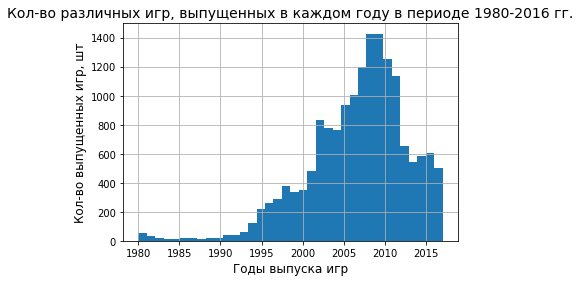

In [8]:
print('Кол-во экземпляров игр, реализованных по 3-м регионам за период наблюдения = ', \
      data['total_sales_3reg'].sum(), 'тыс.шт \n')
# получим кол-во различных игр, выпущенных в каждом году в периоде 1980-2016 год
print(data.groupby('year_of_release')['name'].count())
# построим гистограмму по кол-во различных игр, выпущенных в каждом году в периоде 1980-2016 год
data['year_of_release'].hist(range=(1980,2017), bins=36);
plt.title('Кол-во различных игр, выпущенных в каждом году в периоде 1980-2016 гг.', fontsize=14)
plt.xlabel('Годы выпуска игр', fontsize=12)
plt.ylabel('Кол-во выпущенных игр, шт', fontsize=12)
#print(data.pivot_table(index=['genre'], columns='year_of_release', aggfunc='count'))

#### Анализ продаж по платформам и годам. ####
   **1.** Построена сводная таблица суммарных продаж в 3 региона в зависимости от платформы, отсортирована по убыванию по количеству реализованных игр и построен соответствующий таблице график. Из графика хорошо видны три группы платформ с наибольшей (PS2, X360, Wii, PS3, DS, PS), средней (GBA, PS4, PSP, XB, GB, NES, 3DS, PC, N64, SNES, GC, XOne), наименьшей (2600, WiiU, PSV, SAT, GEN, DC, SCD, NG, WS, TG16, 3DO, GG, PCFX) реализацией. Эти группы были выделены и представлены. Чемпионом по реализации с максимальным результатом 1 062 327 тыс.экземпляров стала платформа PS2 в периоде выпуска игр 2000-2011 гг.  
    **2.** Затем эти группы были дополнительно разбиты по годам выпуска игр внутри каждой группы и представлены на графиках. В группе наибольших продаж хорошо видно характерное "время жизни" платформы, по уровню 25млн.экз.(14-18%% от максимальной реализации) - 7-9 лет, по уровню 50 млн.экз. (29-36%% от максимальной реализации) - 5-7 лет. В других группах указанная картина в общем и целом сохраняется, хотя, конечно, встречаются такие феномены, как крайне неравномерно продававшиеся игры платформы GB или слабо продававшиеся игры с очень долгоживущей платформы РС.  
    Таким образом, в качестве актуального срока для прогноза можно взять срок полупериода "времени жизни" 3-4 года от года выпуска игры. За это время перспективная платформа уже проявляет себя в продажах и может даже выйти на максимум.  
    **3.** Далее применим полученные данные об актуальном периоде и сформируем срез датафрейма по актульному периоду 2013-2016 гг выпуска игр. Построим сводные таблицы по актуальному срезу и просуммируем продажи по 3-м регионам и полностью все продажи аналогично п.1, выведем топ-5 лидеров. Это - (PS4, PS3, XOne, 3DS, X360). Топ-5 платформ актуального периода заметно иной.  
    **4.** Сейчас поставим во главу не платформы, а "календарные" характеристики. Построим сводную таблицу суммарных продаж в 3 региона по годам выпуска игр и отобразим ее на графике. График очень похож на гистограмму кол-ва выпущенных игр по годам. Видим, что максимум продаж приходится на игры 2008-2009 годов выпуска. Затем спад на играх 2010-2011 годов и обвал, но не настолько глубокий как в выпуске игр. Далее фиксация уровня в 2012-2013 годах и затем нарастающий спад в 2014-2016 годах.  
    **5.** Для целей прогноза ситуации 2017 года далее рассмотрим состояние продаж по играм 2013-2016 годов выпуска. Построим графики продаж игр 2013-2016 годов выпуска по платформам и годам внутри платформ, а также по годам и платформам внутри каждого года. Графики отчетливо демонстрируют ситуацию спада. Все наличествующие платформы в состоянии угасания. При экстраполяции близкой к линейной некоторые перспективы на 2017 год есть только у платформ PS4 на уровне 25-30 млн.экз., XOne - 10-12 млн.экз., 3DS - 5-7 млн.экз., РС - 1,5-2 млн.экз.(главное в платформе РС - компьютерные игры 30 лет были и, хоть рекордов по продажам не били, будут и дальше).
    Рассмотрим теперь неучитываемые ранее продажи игр с неизвестным годом выпуска с точки зрения возможности повлиять на прогноз 2017 года. Построим сводную таблицу с неизвестным годом выпуска игр по платформам. Будем делать допущения, направленные на усиление возможности повлиять на прогноз. Для начала положим, что эти продажи относятся к играм 2013-2016 годов выпуска. Если считать, что продажи распределены некоторым образом (равномерно или повторяя существующий характер продаж по годам), то текущее состояние и прогноз не изменятся. Если сделаем максимально сильное допущение, что это продажи игр 2016 года выпуска, то ситуация поменяется для платформ Wii и PS3, где при таком допущении возникает ситуация некоего ренессанса. Однако допущение было сделано очень сильное, потому оно не может быть основанием для изменения прогноза, но может быть основанием для рекомендации не упускать из виду платформы Wii и PS3.


Группа наибольших продаж: 
           total_sales_3reg
platform                  
PS2                1062327
X360                885659
Wii                 828438
PS3                 803966
DS                  746860
PS                  689947 
 Группа средних продаж: 
           total_sales_3reg
platform                  
GBA                 310120
PS4                 265790
PSP                 252630
XB                  249020
GB                  247260
NES                 245739
3DS                 245638
PC                  237139
N64                 214299
SNES                196820
GC                  193750
XOne                145050 
 Группа наименьших продаж: 
           total_sales_3reg
platform                  
2600                 96070
WiiU                 76240
PSV                  47610
SAT                  33520
GEN                  27460
DC                   15680
SCD                   1810
NG                    1440
WS                    1420
TG16                   1

'Топ-5 платформ по суммарным продажам в 3 региона игр с годами выпуска 2013 - 2016 гг.:'

,total_sales_3reg
platform,
PS4,265790
PS3,154659
XOne,145050
3DS,136970
X360,124690


['PS4', 'PS3', 'XOne', '3DS', 'X360']

'Топ-5 платформ по суммарным продажам повсеместно игр с годами выпуска 2013 - 2016 гг.:'

,total_sales
platform,
PS4,314140
PS3,181429
XOne,159320
3DS,143250
X360,136800


['PS4', 'PS3', 'XOne', '3DS', 'X360']


 Сумма продаж в 3 региона с неизвестным годом  выпуска игр: 
                  total_sales_3reg
year_of_release                  
0                           90310 


 Сумма продаж в 3 региона с неизвестным годом  выпуска игр по платформам: 
                           total_sales_3reg
year_of_release platform                  
0               PS2                  19240
                Wii                  14970
                2600                 10430
                X360                  9300
                PS3                   7220
                XB                    5930
                GBA                   4850
                PSP                   3860
                PC                    3260
                DS                    3120
                PS                    3060
                GC                    2150
                3DS                   1100
                GB                     990
                N64                    600
                PSV      

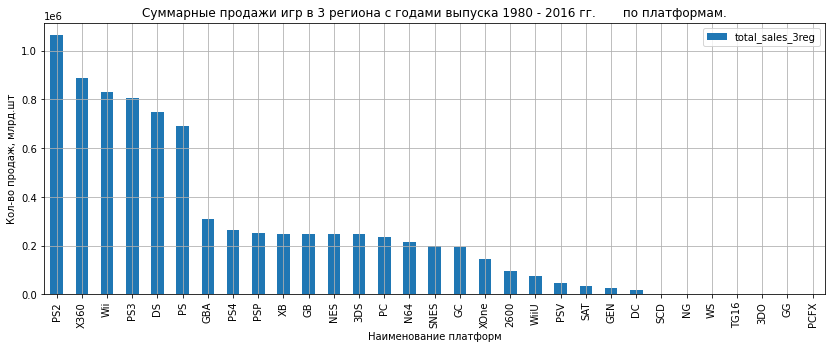

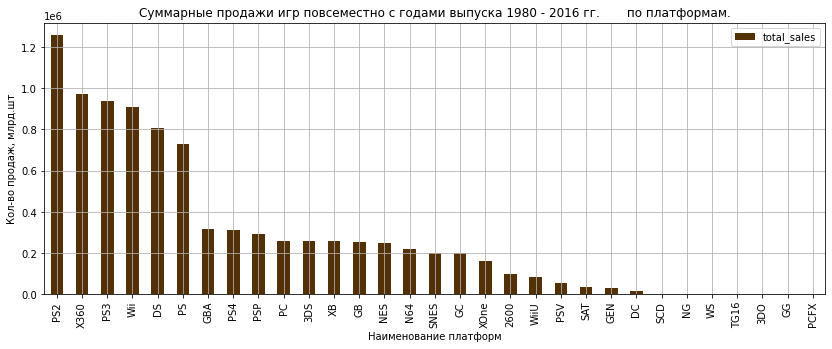

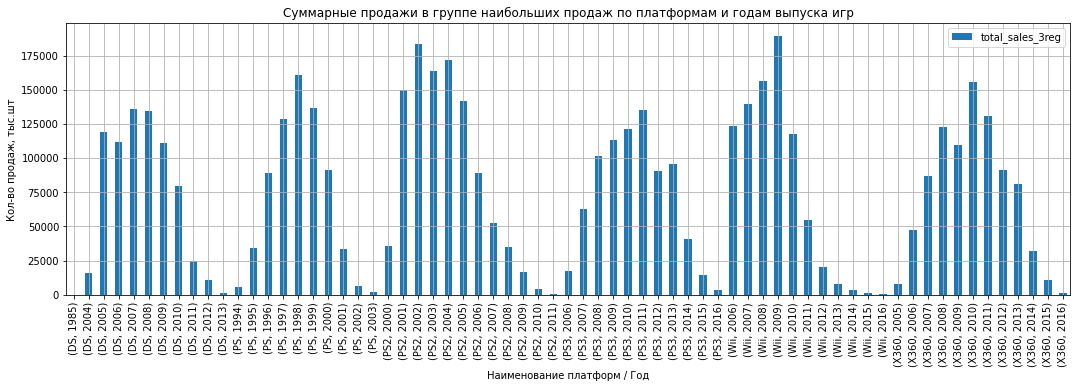

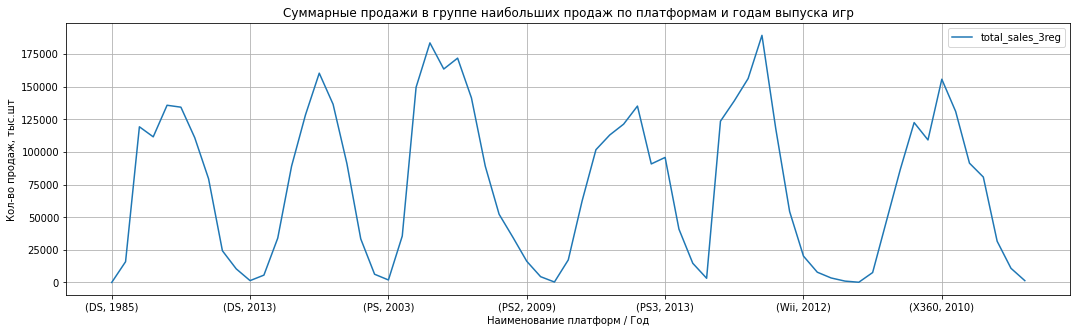

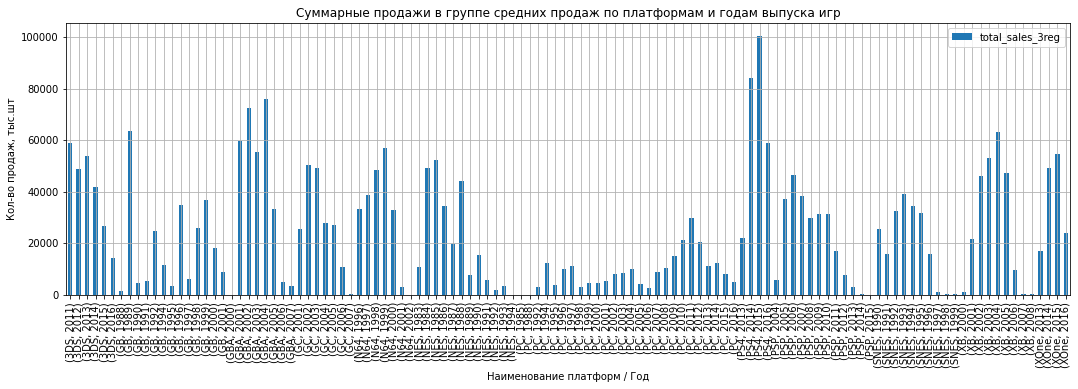

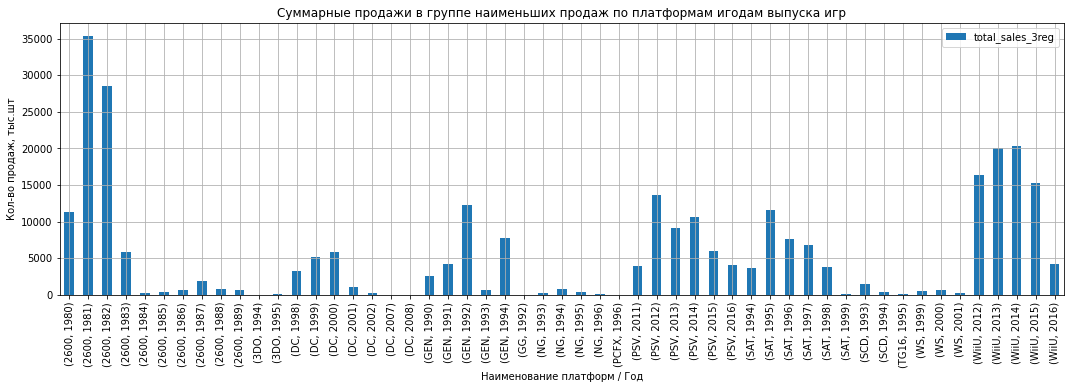

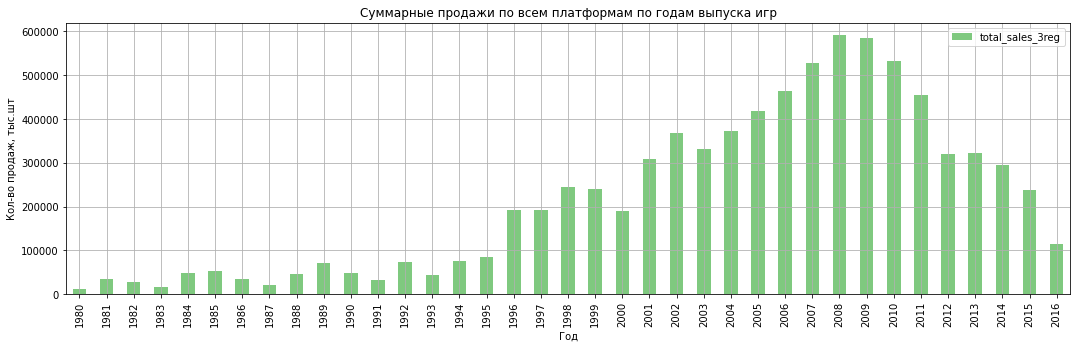

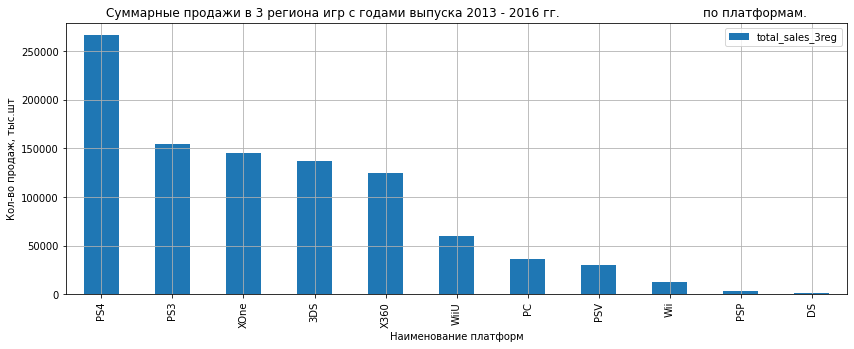

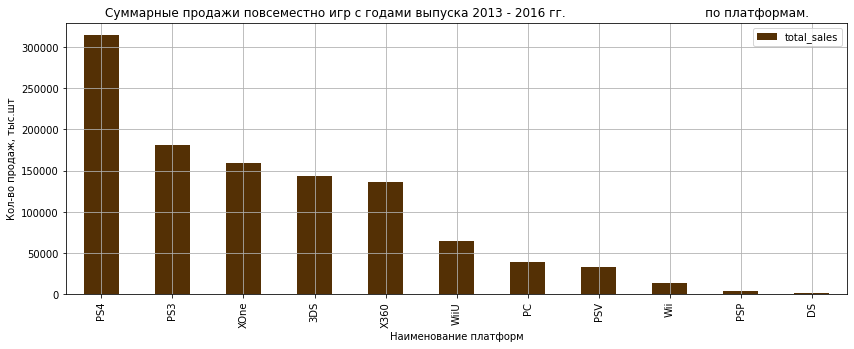

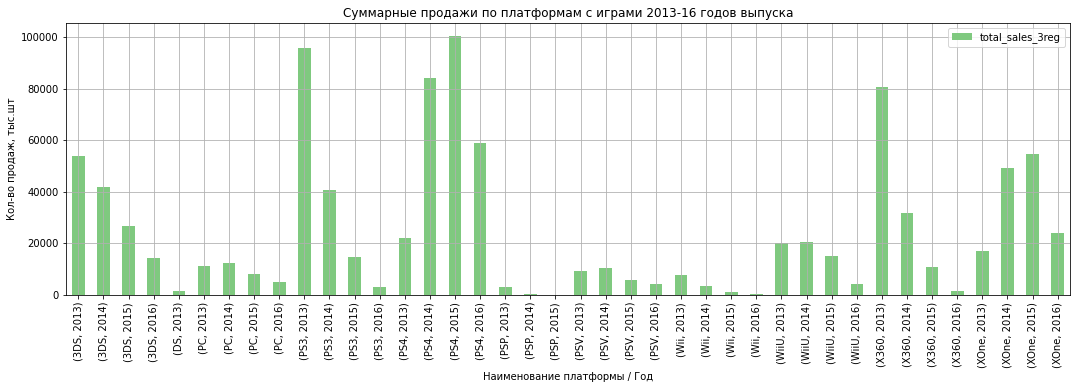

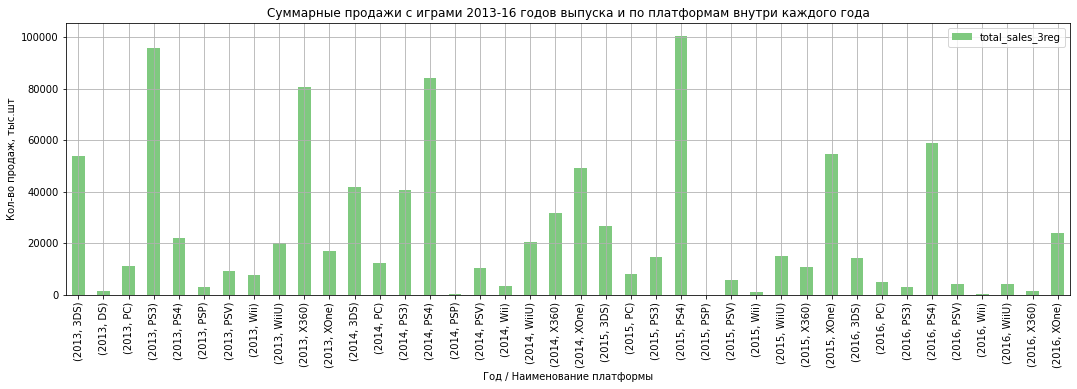

In [9]:
# построим сводную таблицу суммарных продаж в 3 региона в зависимости от платформы и соответствующий ей график
data.pivot_table(index=['platform'], values='total_sales_3reg', aggfunc='sum').\
      sort_values('total_sales_3reg', ascending=False).\
      plot(kind='bar', grid=True, title='Суммарные продажи игр в 3 региона с годами выпуска 1980 - 2016 гг. \
      по платформам.', xlabel='Наименование платформ', ylabel='Кол-во продаж, млрд.шт', figsize=(14, 5))

data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum').\
      sort_values('total_sales', ascending=False).\
      plot(kind='bar', grid=True, title='Суммарные продажи игр повсеместно с годами выпуска 1980 - 2016 гг. \
      по платформам.', xlabel='Наименование платформ', ylabel='Кол-во продаж, млрд.шт',colormap='BrBG',\
           figsize=(14, 5))

# разобъём платформы на 3 группы по объемам продаж
platf_higher_sales = data.pivot_table(index=['platform'], values='total_sales_3reg', aggfunc='sum').\
      sort_values('total_sales_3reg', ascending=False).query('total_sales_3reg > 600000')
platf_middle_sales = data.pivot_table(index=['platform'], values='total_sales_3reg', aggfunc='sum').\
      sort_values('total_sales_3reg', ascending=False).query('100000 <= total_sales_3reg <= 600000')
platf_lower_sales = data.pivot_table(index=['platform'], values='total_sales_3reg', aggfunc='sum').\
      sort_values('total_sales_3reg', ascending=False).query('total_sales_3reg <= 100000')
# выведем состав этих трех групп
print('Группа наибольших продаж:', '\n', platf_higher_sales,'\n', 'Группа средних продаж:', '\n', \
      platf_middle_sales,'\n', 'Группа наименьших продаж:', '\n', platf_lower_sales)

# в каждой из трех групп построим сводные таблицы по годам выпуска игр
platf_higher_sales_year = data.pivot_table(index=['platform', 'year_of_release'], values='total_sales_3reg', \
                                           aggfunc='sum').\
query('year_of_release != 0 and platform in list(@platf_higher_sales.index)')
platf_middle_sales_year = data.pivot_table(index=['platform', 'year_of_release'], values='total_sales_3reg', \
                                           aggfunc='sum').\
query('year_of_release != 0 and platform in list(@platf_middle_sales.index)')
platf_lower_sales_year = data.pivot_table(index=['platform', 'year_of_release'], values='total_sales_3reg', \
                                          aggfunc='sum').\
query('year_of_release != 0 and platform in list(@platf_lower_sales.index)')
# посмотрим группу наибольших продаж по годам выпуска игр
print(platf_higher_sales_year)
# построим графики каждой из трех групп по годам выпуска игр
platf_higher_sales_year.plot(kind='bar', title='Суммарные продажи в группе наибольших продаж по платформам и \
годам выпуска игр', xlabel='Наименование платформ / Год', ylabel='Кол-во продаж, тыс.шт', grid=True, figsize=(18, 5))
platf_higher_sales_year.plot(kind='line', title='Суммарные продажи в группе наибольших продаж по платформам и \
годам выпуска игр', xlabel='Наименование платформ / Год', ylabel='Кол-во продаж, тыс.шт', grid=True, figsize=(18, 5))

platf_middle_sales_year.plot(kind='bar', title='Суммарные продажи в группе средних продаж по платформам и \
годам выпуска игр', xlabel='Наименование платформ / Год', ylabel='Кол-во продаж, тыс.шт',grid=True, figsize=(18, 5))
platf_lower_sales_year.plot(kind='bar', title='Суммарные продажи в группе наименьших продаж по платформам и\
годам выпуска игр', xlabel='Наименование платформ / Год', ylabel='Кол-во продаж, тыс.шт',grid=True, figsize=(18, 5))

# построим сводную таблицу суммарных продаж в 3 региона по годам выпуска игр и соответствующий ей график
year_sales = data.pivot_table(index=['year_of_release'], values='total_sales_3reg', aggfunc='sum').\
query('year_of_release != 0') 
year_sales.plot(kind='bar', title='Суммарные продажи по всем платформам по годам выпуска игр', \
                            xlabel='Год', ylabel='Кол-во продаж, тыс.шт', colormap='Accent', grid=True, \
                            figsize=(18, 5))

# построим актуальную сводную таблицу суммарных продаж в 3 региона в зависимости от платформы и соответствующий ей 
# график
data_rating_sales_2013_16_3reg = \
data.query('year_of_release > 2012').pivot_table(index=['platform'], values='total_sales_3reg', aggfunc='sum').\
    sort_values('total_sales_3reg', ascending=False)
data_rating_sales_2013_16_3reg.plot(kind='bar', grid=True, \
                                    title='Суммарные продажи в 3 региона игр с годами выпуска 2013 - 2016 гг. \
                                    по платформам.', xlabel='Наименование платформ', \
                                    ylabel='Кол-во продаж, тыс.шт', figsize=(14, 5))

# построим актуальную сводную таблицу суммарных продаж повсеместно в зависимости от платформы и соответствующий ей 
# график
data_rating_sales_2013_16_tot = \
data.query('year_of_release > 2012').pivot_table(index=['platform'], values='total_sales', aggfunc='sum').\
      sort_values('total_sales', ascending=False)
data_rating_sales_2013_16_tot.plot(kind='bar', grid=True, \
                                   title='Суммарные продажи повсеместно игр с годами выпуска 2013 - 2016 гг. \
                                   по платформам.', xlabel='Наименование платформ', \
                                   ylabel='Кол-во продаж, тыс.шт',colormap='BrBG', figsize=(14, 5))

display('Топ-5 платформ по суммарным продажам в 3 региона игр с годами выпуска 2013 - 2016 гг.:', 
      data.query('year_of_release > 2012').pivot_table(index=['platform'], values='total_sales_3reg', \
      aggfunc='sum').sort_values('total_sales_3reg', ascending=False).head())
display(list(data_rating_sales_2013_16_tot.index)[:5])

display('Топ-5 платформ по суммарным продажам повсеместно игр с годами выпуска 2013 - 2016 гг.:', \
      data.query('year_of_release > 2012').pivot_table(index=['platform'], values='total_sales', aggfunc='sum').\
      sort_values('total_sales', ascending=False).head())
list_top_5_sale_tot_2013_16 = list(data_rating_sales_2013_16_tot.index)[:5]
display(list_top_5_sale_tot_2013_16)



# построим сводную таблицу суммарных продаж по платформам с играми 2013-16 годов выпуска и соответствующий ей график
sales_platf_year_3 = data.pivot_table(index=['platform', 'year_of_release'], values='total_sales_3reg', \
                                      aggfunc='sum').\
query('year_of_release != 0 and year_of_release > 2012') 
sales_platf_year_3.plot(kind='bar', title='Суммарные продажи по платформам с играми 2013-16 годов выпуска', \
                             xlabel='Наименование платформы / Год', ylabel='Кол-во продаж, тыс.шт', \
                        colormap='Accent',grid=True, figsize=(18, 5))
# построим сводную таблицу суммарных продаж с играми 2013-16 годов выпуска и по платформам в каждом году и соответствующий ей график
year_3_sales_platf = data.pivot_table(index=['year_of_release', 'platform'], values='total_sales_3reg', \
                                      aggfunc='sum').\
query('year_of_release != 0 and year_of_release > 2012')
year_3_sales_platf.plot(kind='bar', title='Суммарные продажи с играми 2013-16 годов выпуска и по платформам внутри каждого года', \
                             xlabel='Год / Наименование платформы', ylabel='Кол-во продаж, тыс.шт', \
                        colormap='Accent',grid=True, figsize=(18, 5))

# построим сводную таблицу суммарных продаж в 3 региона и получим сумму реализации по всем неизвестным годам выпуска
print('\n', 'Сумма продаж в 3 региона с неизвестным годом  выпуска игр:', '\n', \
      data.pivot_table(index=['year_of_release'], values='total_sales_3reg', aggfunc='sum').\
      query('year_of_release == 0'),'\n')
# построим сводную таблицу с неизвестным годом выпуска игр по платформам 
print('\n', 'Сумма продаж в 3 региона с неизвестным годом  выпуска игр по платформам:', '\n', \
      data.pivot_table(index=['year_of_release', 'platform'], values='total_sales_3reg', aggfunc='sum')\
      .query('year_of_release == 0').sort_values('total_sales_3reg', ascending=False),'\n')

print('\n', 'Сумма продаж РС за все время:', '\n', \
      data.pivot_table(index=['platform'], values=['total_sales_3reg', 'total_sales'], aggfunc='sum').\
      query('platform =="PC"'),'\n')

#### Диаграмма разброса ####
   Для построения диаграммы разброса формируем срез исходного датафрейма по топ-5 платформ в актуальном периоде выпуска продаваемых игр. Далее выводим стат.характеристики для каждой платформы этой группы и строим соответствующие диаграммы разброса в двух масштабах, так чтобы на одной диаграмме были видны все значения, включая выбросы, а на другой четко видны стат.характеристики данных - квартили, медиана, интервалы.  
    Из стат характеристик и диаграмм видно, что  
    1. присутствуют выбросы в заметном кол-ве и их амплитуда достаточно велика, но, тем не менее, выбросов не настолько много, чтобы сместить положение медианы в сторону 3-го квартиля. Медиана на всех диаграммах тяготеет к 1-му квартилю.  
    2. средние значения изменяются в диапазоне 470-800 (170%), медиана - 90-265 (294%), максимальные значения - 7400-21100 (285%), минимальные значения одинаковые и равны 10.  
    3. достаточно велики стандартные отклонения от среднего - от 160% до 292%, что говорит о большом диапазоне изменения величин.
    4. из диаграммы видно, что наибольшее число более крупных продаж (но не выбросов, а то, что входит в "ящик", в межквартильный интервал) у Х360, PS4, XOne, за счет чего и сами "ящики" и средние значения и медианы соответственно растут. Однако лидером по продажам является PS3, у которого меньший "средний чек" (в натуральных показателях, шт) компенсируется большим числом фактов продаж, количеством продаж.

'Срез по топ-5 платформ в актуальный периоде 2013-2016 гг.'

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales_3reg,total_sales
16,16,Grand Theft Auto V,PS3,2013,Action,7020,9090,980,3960,97,82,M,17090,21050
23,23,Grand Theft Auto V,X360,2013,Action,9660,5140,60,1410,97,81,M,14860,16270
31,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6030,5860,360,2380,unknown,unknown,unknown,12250,14630
33,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5280,4190,4350,780,unknown,unknown,unknown,13820,14600
42,42,Grand Theft Auto V,PS4,2014,Action,3960,6310,380,1970,97,83,M,10650,12620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16670,16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,10,0,0,0,unknown,unknown,M,10,10
16672,16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0,10,0,0,unknown,unknown,unknown,10,10
16675,16677,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0,0,10,0,unknown,unknown,unknown,10,10
16689,16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0,0,10,0,unknown,unknown,unknown,10,10


'платформа'

'PS4'

count      392.000000
mean       801.377551
std       1609.456276
min         10.000000
25%         60.000000
50%        200.000000
75%        730.000000
max      14630.000000
Name: total_sales, dtype: float64

'платформа'

'PS3'

count      345.000000
mean       525.881159
std       1451.929819
min         10.000000
25%         40.000000
50%        150.000000
75%        510.000000
max      21050.000000
Name: total_sales, dtype: float64

'платформа'

'XOne'

count     247.000000
mean      645.020243
std      1036.138812
min        10.000000
25%        60.000000
50%       220.000000
75%       685.000000
max      7390.000000
Name: total_sales, dtype: float64

'платформа'

'3DS'

count      303.000000
mean       472.772277
std       1381.346727
min         10.000000
25%         40.000000
50%         90.000000
75%        280.000000
max      14600.000000
Name: total_sales, dtype: float64

'платформа'

'X360'

count      186.000000
mean       735.483871
std       1663.275190
min         10.000000
25%         80.000000
50%        265.000000
75%        795.000000
max      16270.000000
Name: total_sales, dtype: float64

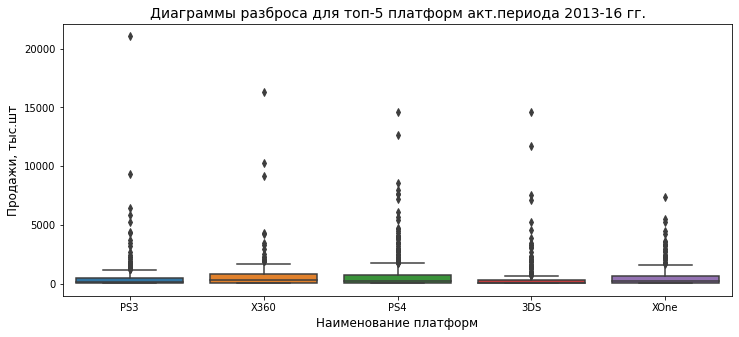

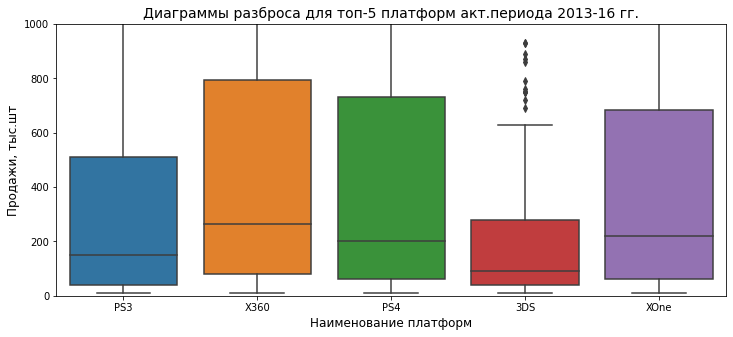

In [10]:
# сформируем срез по топ-5 платформ в актуальный срок
data_top_5_act_per = data.query('year_of_release > 2012 and \
                                platform in (@list_top_5_sale_tot_2013_16)')
display('Срез по топ-5 платформ в актуальный периоде 2013-2016 гг.', data_top_5_act_per)

for val in (list_top_5_sale_tot_2013_16):
    display('платформа', val, data_top_5_act_per.query('platform == @val')['total_sales'].describe())

# построим диаграмму разброса для топ-5 платформ в акт.периоде
plt.figure(figsize=(12,5))
sns.boxplot(x=data_top_5_act_per['platform'], y=data_top_5_act_per['total_sales'])
plt.title('Диаграммы разброса для топ-5 платформ акт.периода 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

# построим диаграмму разброса для топ-5 платформ в акт.периоде в другом масштабе
plt.figure(figsize=(12,5))
sns.boxplot(x=data_top_5_act_per['platform'], y=data_top_5_act_per['total_sales'])
plt.ylim(0, 1000)
plt.title('Диаграммы разброса для топ-5 платформ акт.периода 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);


#### Влияние отзывов экспертов и пользователей. ####  
Оценим влияние отзывов экспертов и пользователей на продаваемость игр. Найдем корреляцию между столбцом продаж "total_sales_3reg" и столбцами оценок экспертов 'critic_score' и оценок пользователей 'user_score', одновременно выведем статистические характеристики столбцов оценок. Сделаем это для лидера продаж платформы PS2 и платформы WiiU с более чем в 30 раз худшими результатами по продажам.  
    **Коэффициенты корреляции** "total_sales_3reg" с 'critic_score' и 'user_score' для платформы PS2 составляют (0,41; 0,19), что соответствует слабой и очень слабой корреляции. Аналогичные показатели для платформы WiiU - (0,35; 0,40), что соотвествует слабой корреляции. Таким образом, картина по корреляции практически идентичная.  
    **Посмотрим стат.характеристики** оценок для этих платформ. Кол-во оценок, средние значение оценок и медианы оценок экспертов и пользователей для платформы PS2 - (1298, 69, 70) и (1241, 76, 80) соответственно. Эти же показатели для платформы WiiU - (90, 71, 74) и (100, 69, 71) соотвественно.  
    **Итог:** корреляции одинаковы, оценки экспертов не отличаются, оценки пользователей отличаются на 10%, объём продаж различается более, чем в 30 раз. Заметное отличие в кол-ве оценок экспертов и пользователей для одной и другой платформ. У много более продаваемой платформы PS2 в разы большее кол-во оценок и экспертов и пользователей, но это скорее следствие большей продаваемости - про предмет на слуху и на виду всем хочется чего-то сказать, особенно экспертам.  
    **Таким образом, зависимость продаваемости от уровня экспертных и пользовательских оценок практически отсутствует.** Слабую корреляцию между столбцом продаж и столбцами оценок можно объяснить бОльшим желанием высказаться экспертов и пользователей по поводу более популярного продукта. Оценки пользователей и экспертов могут быть "вишенкой на торте" большой рекламной компании, но самостоятельного значения для продавемости продукта практически не имеют.  
    Есть только одно"но". Рассмотренные платформы действовали в различные временные интервалы, PS2 - (2000 - 2008), WiiU - (2012, 2016). С течением времени что-то могло заметно измениться. В связи с этим, рассмотрим все эти характеристики для платформы 'GC', которая действовала в том же периоде (2001-2006), что и PS2, и "продаваемость" у 'GC' в 7 раз ниже, чем у PS2.  
    Для 'GC' коэффициенты корреляции "total_sales_3reg" с 'critic_score' и 'user_score' составляют (0,33; 0,23), что соответствует слабой корреляции. Кол-во оценок, среднее значение оценок и медиана оценок экспертов и пользователей для платформы 'GC' - (448, 69, 70) и (366, 76, 80) соответственно. На мой взгляд, полное подтверждение ранее сделанного вывода.

Стат.характеристики оценок критиков игр платформы "PS2": 
 count    1298.000000
mean       68.727273
std        13.075177
min        24.000000
25%        60.000000
50%        70.000000
75%        78.000000
max        97.000000
Name: critic_score, dtype: float64 

Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "critic_score" = 0.40812824398272646


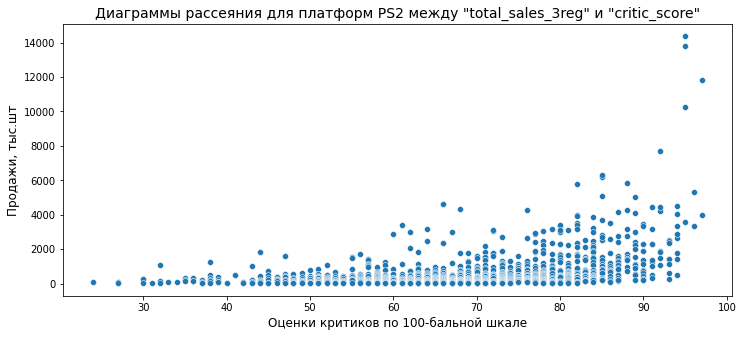

Стат.характеристики оценок пользователей игр платформы "PS2": 
 count    1241.000000
mean       76.268332
std        13.093018
min        17.000000
25%        70.000000
50%        80.000000
75%        86.000000
max        95.000000
Name: user_score, dtype: float64 

Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "user_score" = 0.18540950689780944


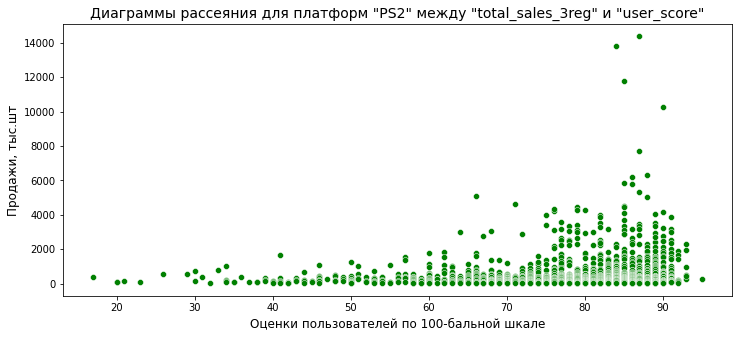

Стат.характеристики оценок критиков игр платформы "WiiU": 
 count    90.000000
mean     70.733333
std      14.689903
min      24.000000
25%      65.250000
50%      73.500000
75%      81.000000
max      93.000000
Name: critic_score, dtype: float64 

Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "critic_score" = 0.34706169744855453


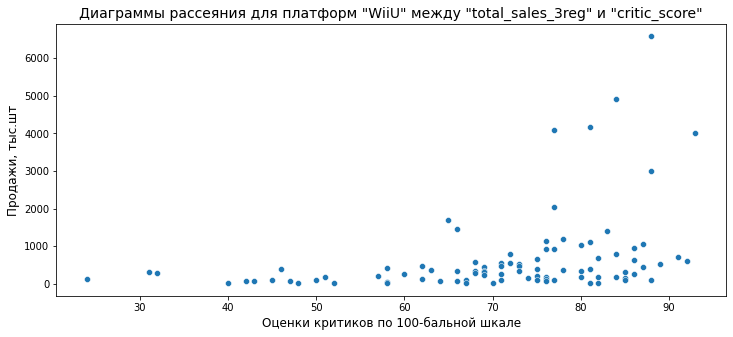

Стат.характеристики оценок пользователей игр платформы "WiiU": 
 count    100.000000
mean      69.040000
std       14.354051
min       27.000000
25%       62.000000
50%       71.000000
75%       79.250000
max       91.000000
Name: user_score, dtype: float64 

Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "user_score" = 0.3992109927499904


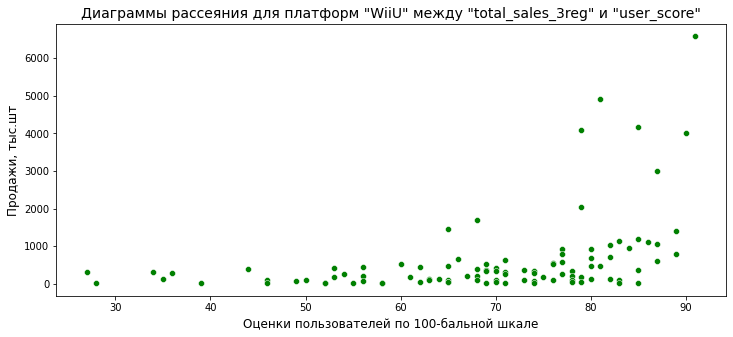

Стат.характеристики оценок критиков игр платформы "GC": 
 count    448.000000
mean      69.488839
std       13.439561
min       23.000000
25%       61.000000
50%       70.000000
75%       80.000000
max       97.000000
Name: critic_score, dtype: float64 

Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "critic_score" = 0.3254763908357056


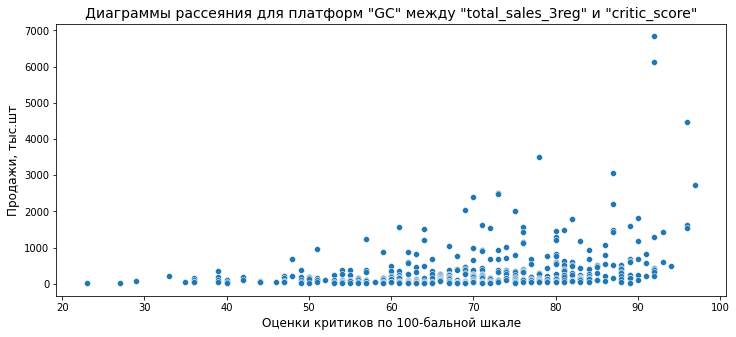

Стат.характеристики оценок пользователей игр платформы "GC": 
 count    366.000000
mean      75.975410
std       13.748104
min       14.000000
25%       70.000000
50%       79.500000
75%       85.000000
max       94.000000
Name: user_score, dtype: float64 

Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "user_score" = 0.23436319539230538


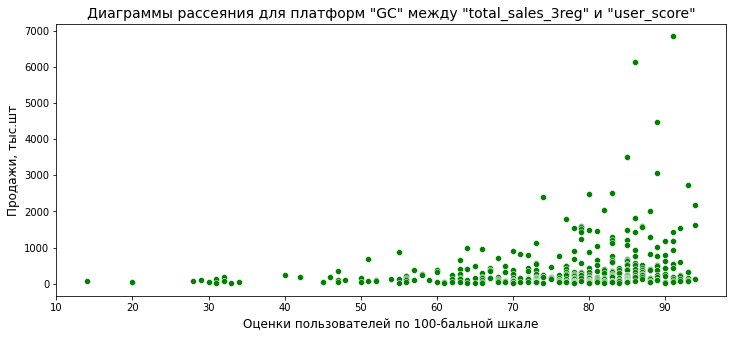

In [11]:
# -----PS2------
# для лидера продаж - платформы PS2 - подготовим столбец 'critic_score', из которого уберем все значения 'unknown'
data_PS2 = data.loc[(data['platform'] == 'PS2') & (data['critic_score'] != 'unknown')]
# поменяем тип на 'int'
data_PS2['critic_score'] = data_PS2['critic_score'].astype('int')
print('Стат.характеристики оценок критиков игр платформы "PS2":', '\n', data_PS2['critic_score'].describe(), '\n')
# посчитаем корреляцию между "total_sales_3reg" и "critic_score"
print('Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "critic_score" =', \
      data_PS2['total_sales_3reg'].corr(data_PS2['critic_score']))
# построим диаграмму рассеяния
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_PS2, x='critic_score', y='total_sales_3reg');
plt.title('Диаграммы рассеяния для платформ PS2 между "total_sales_3reg" и "critic_score"', fontsize=14) 
plt.xlabel('Оценки критиков по 100-бальной шкале', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12)
plt.show()

# теперь все то же самое для столбца 'user_score' - подготавливаем, уберем все значения 'unknown'
data_PS2 = data.loc[(data['platform'] == 'PS2') & (data['user_score'] != 'unknown')]
# поменяем тип на 'int'
data_PS2['user_score'] = data_PS2['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "PS2":', '\n', data_PS2['user_score'].describe(), '\n')
# посчитаем корреляцию между "total_sales_3reg" и "user_score"
print('Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "user_score" =', \
      data_PS2['total_sales_3reg'].corr(data_PS2['user_score']))
plt.figure(figsize=(12,5))
# построим диаграмму рассеяния
sns.scatterplot(data=data_PS2, x='user_score', y='total_sales_3reg', color="green");
plt.title('Диаграммы рассеяния для платформ "PS2" между "total_sales_3reg" и "user_score"', fontsize=14) 
plt.xlabel('Оценки пользователей по 100-бальной шкале', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12)
plt.show()

# -----WiiU------
data_WiiU = data.loc[(data['platform'] == 'WiiU') & (data['critic_score'] != 'unknown')]
data_WiiU['critic_score'] = data_WiiU['critic_score'].astype('int')
print('Стат.характеристики оценок критиков игр платформы "WiiU":', '\n', data_WiiU['critic_score'].describe(), '\n')
print('Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "critic_score" =', \
      data_WiiU['total_sales_3reg'].corr(data_WiiU['critic_score']))
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_WiiU, x='critic_score', y='total_sales_3reg');
plt.title('Диаграммы рассеяния для платформ "WiiU" между "total_sales_3reg" и "critic_score"', fontsize=14) 
plt.xlabel('Оценки критиков по 100-бальной шкале', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12)
plt.show()

data_WiiU = data.loc[(data['platform'] == 'WiiU') & (data['user_score'] != 'unknown')]
data_WiiU['user_score'] = data_WiiU['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "WiiU":', '\n', data_WiiU['user_score'].describe(), '\n')
print('Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "user_score" =', \
      data_WiiU['total_sales_3reg'].corr(data_WiiU['user_score']))
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_WiiU, x='user_score', y='total_sales_3reg', color="green");
plt.title('Диаграммы рассеяния для платформ "WiiU" между "total_sales_3reg" и "user_score"', fontsize=14) 
plt.xlabel('Оценки пользователей по 100-бальной шкале', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12)
plt.show()


data_GC = data.loc[(data['platform'] == 'GC') & (data['critic_score'] != 'unknown')]
data_GC['critic_score'] = data_GC['critic_score'].astype('int')
print('Стат.характеристики оценок критиков игр платформы "GC":', '\n', data_GC['critic_score'].describe(), '\n')
print('Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "critic_score" =', \
      data_GC['total_sales_3reg'].corr(data_GC['critic_score']))
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_GC, x='critic_score', y='total_sales_3reg');
plt.title('Диаграммы рассеяния для платформ "GC" между "total_sales_3reg" и "critic_score"', fontsize=14) 
plt.xlabel('Оценки критиков по 100-бальной шкале', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12)
plt.show()

# -----GC------
data_GC = data.loc[(data['platform'] == 'GC') & (data['user_score'] != 'unknown')]
data_GC['user_score'] = data_GC['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "GC":', '\n', data_GC['user_score'].describe(), '\n')
print('Коэффициент корреляции (Пирсона) между "total_sales_3reg" и "user_score" =', \
      data_GC['total_sales_3reg'].corr(data_GC['user_score']))
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_GC, x='user_score', y='total_sales_3reg', color="green");
plt.title('Диаграммы рассеяния для платформ "GC" между "total_sales_3reg" и "user_score"', fontsize=14) 
plt.xlabel('Оценки пользователей по 100-бальной шкале', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12)
plt.show()

#### Анализ жанров ####  
  **1.** Представлены диаграммы распределения по жанрам кол-ва наименований различных игр и распределение по жанрам кол-ва проданных игр за все годы выпуска 1980-2016гг. Диаграммы не тождественны. ТОП-5 жанров по кол-ву выпущенных наименований - (Action, Sports, Misc, Role-Playing, Shooter). ТОП-5 проданных в 3 региона игр тех же годов выпуска - (Action, Sports, Shooter, Role-Playing, Platform). Топ-2 жанров совпадают и по разнообразию игр и по кол-ву проданных экземпляров, это Action и Sports. Занимающий же третье место по разнообразию игр жанр Misc продается хуже менее разнообразного Shooter (5-ое место). И по продажам на третьем месте Shooter, а Misc лишь на 6-ом.  
   **2.** Представлены диаграммы распределения по жанрам кол-ва наименований различных игр и распределение по жанрам кол-ва проданных в 3 региона игр акт.периода 2013-2016гг выпуска. ТОП-5 жанров по кол-ву выпущенных наименований в актульном периоде - (Action, Adventure, Fighting, Misc, Platform). Видно существенное жанровое отличие по сравнению с результатами за весь период выпуска игр 1980-2016гг. ТОП-5 проданных в 3 региона игр актуального периода 2013-2016 гг - (Action, Shooter, Role-Playing, Sports, Мisc) и также заметно отличается от ТОП-5 жанров за период 1980-2016гг. ТОП-5 выпущенных и ТОП-5 проданных в 3 региона в актульном периоде заметно отличаются друг от друга.  
   **3.** Представлена диаграмма распределения по жанрам кол-ва проданных **повсеместно** игр актуального периода. ТОП-5 этих жанров - (Action, Shooter, Sports, Role-Playing, Misc). От ТОП-5 продаж в 3 региона актуального периода отличается только перестановкой 3-го и 4-го места.  
   **4.** Представлены стат.характеристики данных и диаграммы разброса для ТОП-5 жанров в актульном периоде в 2-х масштабах.  
   Из стат.характеристик и диаграмм разброса видны довольно большие различия в стат.характеристиках продаж для жанров Shooter и Sports. В этих жанрах по сравнению с Action, Role-Playing, Мisc заметно выше медиана (3,6-4,5 раз), уровень 1-го (до 4,7 раз) и 3-го (до 4,3 раз) квартилей, среднее значение (1,4-3,1 раз), при этом кол-во продаж меньше или почти такое же, как и в остальных жанрах. Это говорит о специфичности продаж этих жанров, где продаж меньше или столько же, но кол-во продаваемых за 1 продажу игр заметно больше. Возможно, это связано с большей направленностью игр этих жанров на многопользовательскую, командную игру, что и влечет массовых покупателей. Но кол-во таких покупателей все-таки меньше и потому лидером является жанр Action, где продажи за 1 раз меньше, но кол-во самих продаж, в 1-ую очередь индивидуалам, много больше.

'(гист.) Распределение по жанрам кол-ва различных игр, выпущенных в периоде 1980-2016 год'

,genre,name
0,Action,3369
10,Sports,2348
3,Misc,1750
7,Role-Playing,1498
8,Shooter,1323
1,Adventure,1303
6,Racing,1249
4,Platform,888
9,Simulation,873
2,Fighting,849


'(гист.) ТОП-5 по жанрам кол-ва различных игр, выпущенных в периоде 1980-2016 год'

0           Action
10          Sports
3             Misc
7     Role-Playing
8          Shooter
Name: genre, dtype: object

'(гист.) Распределение по жанрам кол-ва различных игр, выпущенных в акт.периоде 2013-2016гг'

,genre,name
0,Action,766
7,Role-Playing,292
1,Adventure,245
10,Sports,214
8,Shooter,187
3,Misc,155
6,Racing,85
2,Fighting,80
4,Platform,74
9,Simulation,62


'(гист.) ТОП-5 по жанрам кол-ва различных игр, выпущенных в акт.периоде 2013-2016гг'

,genre,name
0,Action,766
1,Adventure,245
2,Fighting,80
3,Misc,155
4,Platform,74


'(диаг.) Распределение по жанрам кол-ва игр, проданных в 3 рег.в периоде 1980-2016гг'

,genre,total_sales_3reg
0,Action,1559567
10,Sports,1196757
8,Shooter,948338
7,Role-Playing,874930
4,Platform,776680
3,Misc,728118
6,Racing,652567
2,Fighting,411167
9,Simulation,359238
5,Puzzle,230190


'(диаг.) ТОП-5 по жанрам кол-ва игр, проданных в 3 рег.в периоде 1980-2016гг'

0           Action
10          Sports
8          Shooter
7     Role-Playing
4         Platform
Name: genre, dtype: object

'(диаг.) Распределение по жанрам кол-ва игр, проданных в 3 рег.в акт.периоде 2013-2016гг'

,genre,total_sales_3reg
0,Action,284670
8,Shooter,204210
7,Role-Playing,134410
10,Sports,131200
3,Misc,56729
4,Platform,38510
6,Racing,35450
2,Fighting,31750
1,Adventure,21210
9,Simulation,20300


'(диаг.) ТОП-5 по жанрам кол-ва игр, проданных в 3 рег.в акт.периоде 2013-2016гг'

0           Action
8          Shooter
7     Role-Playing
10          Sports
3             Misc
Name: genre, dtype: object

'(диаг.) Распределение по жанрам кол-ва игр, проданных повсеместно в акт.периоде 2013-2016гг'

,genre,total_sales
0,Action,321870
8,Shooter,232980
10,Sports,150650
7,Role-Playing,145890
3,Misc,62819
4,Platform,42630
6,Racing,39890
2,Fighting,35310
1,Adventure,23640
9,Simulation,21760


'(диаг.) ТОП-5 по жанрам кол-ва игр, проданных повсеместно в акт.периоде 2013-2016гг'

0           Action
8          Shooter
10          Sports
7     Role-Playing
3             Misc
Name: genre, dtype: object

'(ящик) ТОП-5 по жанрам кол-ва игр, проданных повсеместно в акт.периоде 2013-2016гг'

0           Action
8          Shooter
10          Sports
7     Role-Playing
3             Misc
Name: genre, dtype: object

'Срез исходного датафрейма по топ-5 жанров по повсеместным продажам игр акт.периоде 2013-2016 гг.выпуска'

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales_3reg,total_sales
16,16,Grand Theft Auto V,PS3,2013,Action,7020,9090,980,3960,97,82,M,17090,21050
23,23,Grand Theft Auto V,X360,2013,Action,9660,5140,60,1410,97,81,M,14860,16270
31,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6030,5860,360,2380,unknown,unknown,unknown,12250,14630
33,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5280,4190,4350,780,unknown,unknown,unknown,13820,14600
42,42,Grand Theft Auto V,PS4,2014,Action,3960,6310,380,1970,97,83,M,10650,12620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16689,16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0,0,10,0,unknown,unknown,unknown,10,10
16690,16692,Metal Gear Solid V: Ground Zeroes,PC,2014,Action,0,10,0,0,80,76,M,10,10
16697,16699,The Longest 5 Minutes,PSV,2016,Action,0,0,10,0,unknown,unknown,unknown,10,10
16705,16707,Aiyoku no Eustia,PSV,2014,Misc,0,0,10,0,unknown,unknown,unknown,10,10


'жанр'

'Action'

count      766.000000
mean       420.195822
std       1253.909479
min         10.000000
25%         30.000000
50%        110.000000
75%        337.500000
max      21050.000000
Name: total_sales, dtype: float64

'жанр'

'Shooter'

count      187.000000
mean      1245.882353
std       2014.106875
min         10.000000
25%        140.000000
50%        450.000000
75%       1425.000000
max      14630.000000
Name: total_sales, dtype: float64

'жанр'

'Sports'

count     214.000000
mean      703.971963
std      1219.237281
min        10.000000
25%        70.000000
50%       240.000000
75%       765.000000
max      8580.000000
Name: total_sales, dtype: float64

'жанр'

'Role-Playing'

count      292.000000
mean       499.623288
std       1353.163861
min         10.000000
25%         60.000000
50%        125.000000
75%        382.500000
max      14600.000000
Name: total_sales, dtype: float64

'жанр'

'Misc'

count     155.000000
mean      405.283871
std      1007.953222
min        10.000000
25%        30.000000
50%       100.000000
75%       330.000000
max      9180.000000
Name: total_sales, dtype: float64

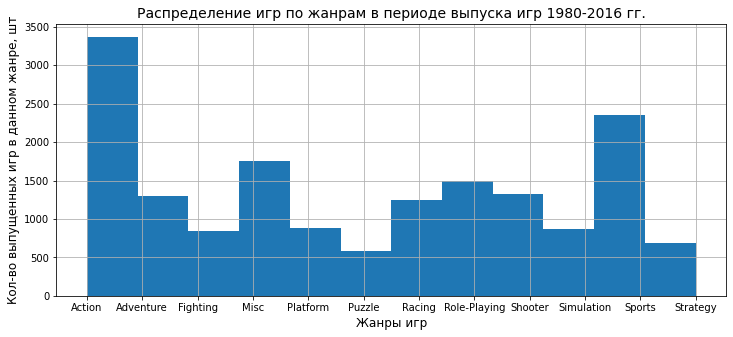

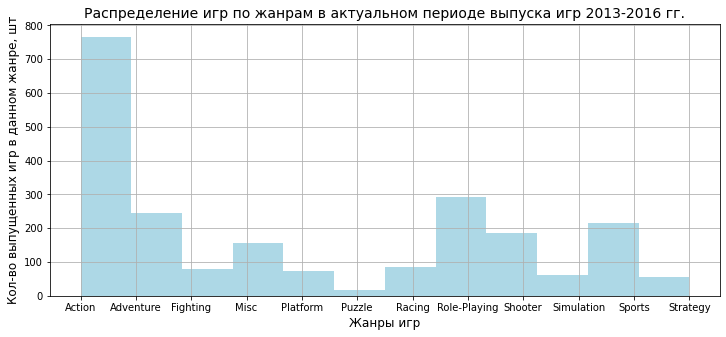

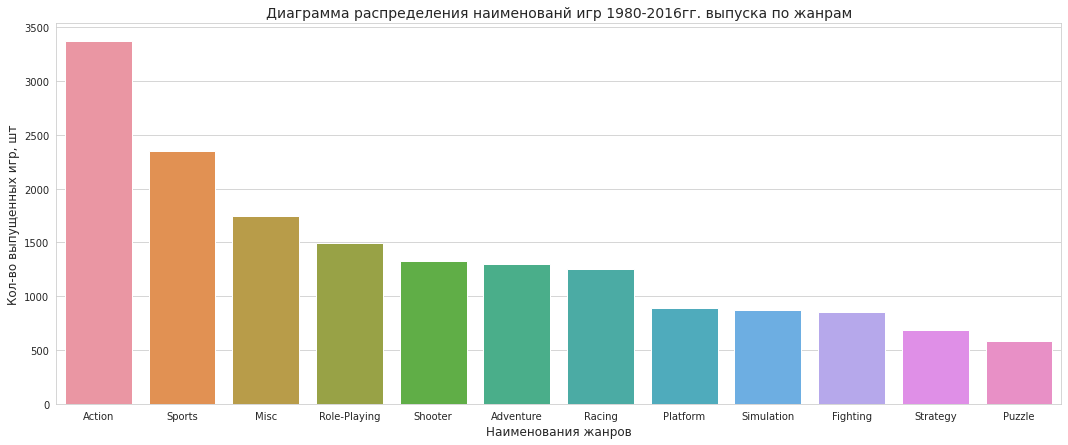

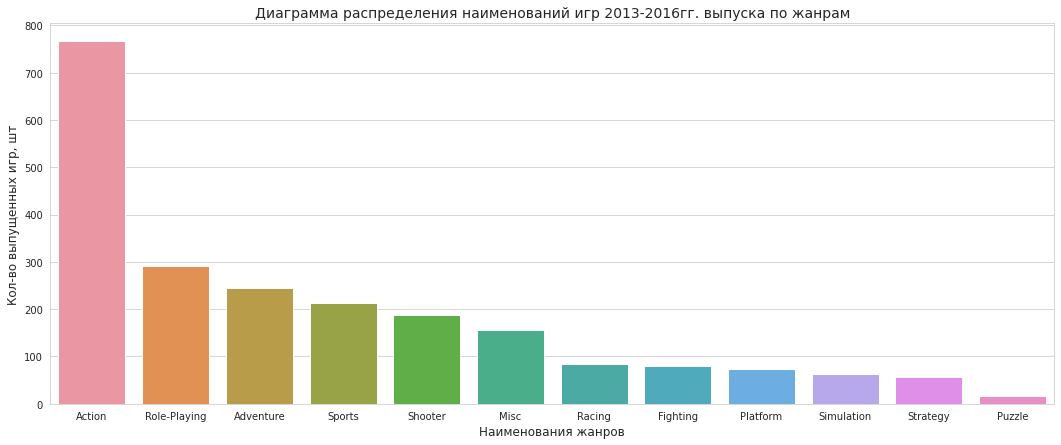

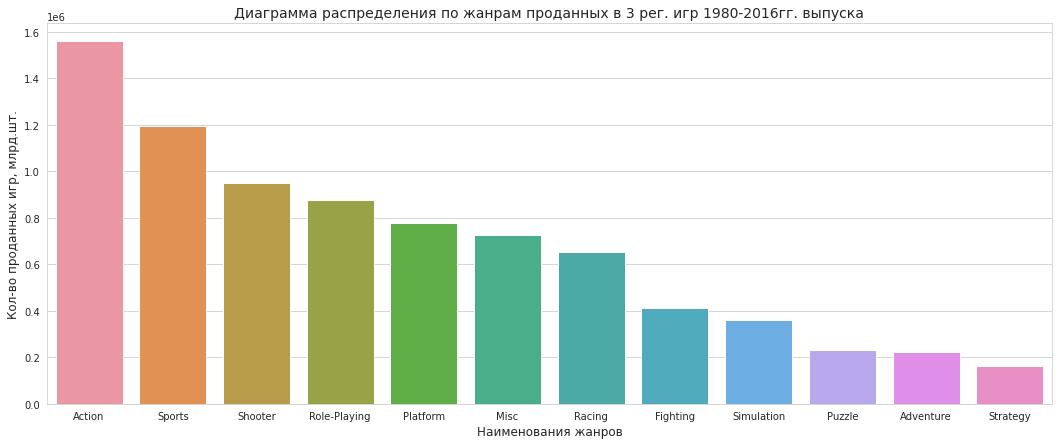

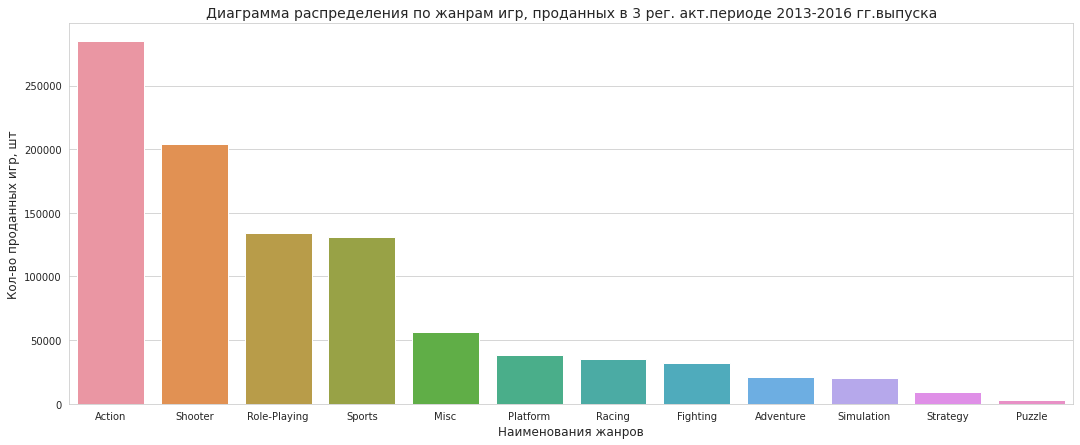

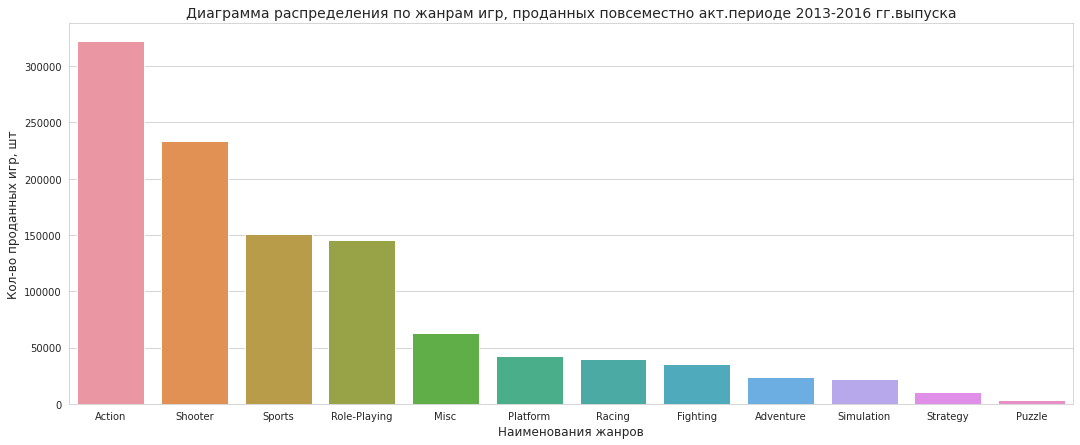

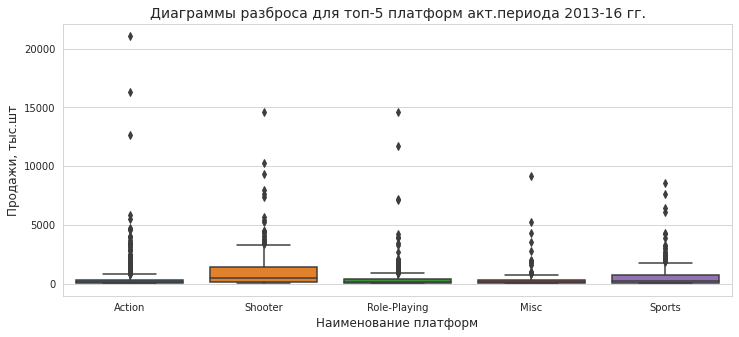

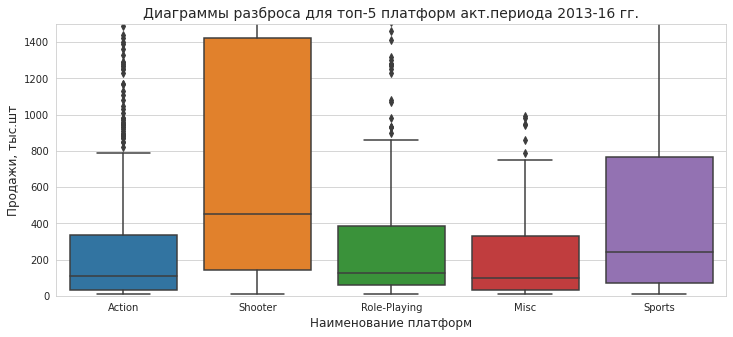

In [12]:
# получим распределение различных игр по жанрам
data_genre = data.groupby('genre')['name'].count().reset_index()
data_genre = data_genre.sort_values('name', ascending=False)
display('(гист.) Распределение по жанрам кол-ва различных игр, выпущенных в периоде 1980-2016 год', data_genre)
display('(гист.) ТОП-5 по жанрам кол-ва различных игр, выпущенных в периоде 1980-2016 год', data_genre['genre'].head())

# построим гистограмму по кол-во различных игр, выпущенных в каждом году в периоде 1980-2016 год
plt.figure(figsize=(12,5))
data.sort_values('genre')['genre'].hist(bins=12);
plt.title('Распределение игр по жанрам в периоде выпуска игр 1980-2016 гг.', fontsize=14)
plt.xlabel('Жанры игр', fontsize=12)
plt.ylabel('Кол-во выпущенных игр в данном жанре, шт', fontsize=12)

# построим гистограмму по кол-во различных игр, выпущенных в каждом году в акт.периоде 2013-2016 гг.
display('(гист.) Распределение по жанрам кол-ва различных игр, выпущенных в акт.периоде 2013-2016гг', 
        data.query('year_of_release > 2012').groupby('genre')['name'].count().reset_index().
        sort_values('name', ascending=False))
display('(гист.) ТОП-5 по жанрам кол-ва различных игр, выпущенных в акт.периоде 2013-2016гг', 
        data.query('year_of_release > 2012').groupby('genre')['name'].count().reset_index().
        sort_values('genre').head())

plt.figure(figsize=(12,5))
data.query('year_of_release > 2012').sort_values('genre')['genre'].hist(bins=12, color ="lightblue");
plt.title('Распределение игр по жанрам в актуальном периоде выпуска игр 2013-2016 гг.', fontsize=14)
plt.xlabel('Жанры игр', fontsize=12)
plt.ylabel('Кол-во выпущенных игр в данном жанре, шт', fontsize=12)


# построим диаграмму распределения наименований игр по жанрам в периоде 1980-2016 год
sns.set_style("whitegrid")
plt.figure(figsize=(18,7))
sns.barplot(data=data_genre, x="genre", y="name")
plt.title('Диаграмма распределения наименованй игр 1980-2016гг. выпуска по жанрам', fontsize=14)
plt.xlabel('Наименования жанров', fontsize=12)
plt.ylabel('Кол-во выпущенных игр, шт', fontsize=12);

# построим диаграмму по кол-во различных игр, выпущенных в каждом году в акт.периоде 2013-2016 гг.
data_genre_act_per = (data.query('year_of_release > 2012').groupby('genre')['name'].count().
                      reset_index().sort_values('name', ascending=False))
#display('(диаг.) Распределение наименований игр 2013-2016гг. выпуска по жанрам ', data_genre_act_per)
sns.set_style("whitegrid")
plt.figure(figsize=(18,7))
sns.barplot(data=data_genre_act_per, x="genre", y="name")
plt.title('Диаграмма распределения наименований игр 2013-2016гг. выпуска по жанрам', fontsize=14)
plt.xlabel('Наименования жанров', fontsize=12)
plt.ylabel('Кол-во выпущенных игр, шт', fontsize=12);


# посмотрим распределение кол-ва проданных игр по жанрам в периоде 1980-2016 год
data_genre = data.groupby('genre')['total_sales_3reg'].sum().reset_index()
data_genre = data_genre.sort_values('total_sales_3reg', ascending=False)
# построим диаграмму распределения проданных в 3 рег.игр по жанрам в периоде 1980-2016 год
display('(диаг.) Распределение по жанрам кол-ва игр, проданных в 3 рег.в периоде 1980-2016гг', 
        data_genre)
display('(диаг.) ТОП-5 по жанрам кол-ва игр, проданных в 3 рег.в периоде 1980-2016гг', 
        data_genre['genre'].head())
sns.set_style("whitegrid")
plt.figure(figsize=(18,7))
sns.barplot(data=data_genre, x="genre", y="total_sales_3reg")
plt.title('Диаграмма распределения по жанрам проданных в 3 рег. игр 1980-2016гг. выпуска', fontsize=14)
plt.xlabel('Наименования жанров', fontsize=12)
plt.ylabel('Кол-во проданных игр, млрд.шт.', fontsize=12);

# построим диаграмму распределения по жанрам игр, проданных в 3 рег. акт.периоде 2013-2016 гг.выпуска
data_genre_act_per = (data.query('year_of_release > 2012').groupby('genre')['total_sales_3reg'].sum().
                      reset_index().sort_values('total_sales_3reg', ascending=False)
                       )
display('(диаг.) Распределение по жанрам кол-ва игр, проданных в 3 рег.в акт.периоде 2013-2016гг',
        data.query('year_of_release > 2012').groupby('genre')['total_sales_3reg'].sum().reset_index().
        sort_values('total_sales_3reg', ascending=False)
                       )
display('(диаг.) ТОП-5 по жанрам кол-ва игр, проданных в 3 рег.в акт.периоде 2013-2016гг',
        data.query('year_of_release > 2012').groupby('genre')['total_sales_3reg']
        .sum().reset_index().sort_values('total_sales_3reg', ascending=False)['genre'].head()
                       )
sns.set_style("whitegrid")
plt.figure(figsize=(18,7))
sns.barplot(data=data_genre_act_per, x="genre", y="total_sales_3reg")
plt.title('Диаграмма распределения по жанрам игр, проданных в 3 рег. акт.периоде 2013-2016 гг.выпуска', fontsize=14)
plt.xlabel('Наименования жанров', fontsize=12)
plt.ylabel('Кол-во проданных игр, шт', fontsize=12);

# построим диаграмму распределения по жанрам игр, проданных повсеместно акт.периоде 2013-2016 гг.выпуска
data_genre_act_per_tot = (data.query('year_of_release > 2012').groupby('genre')['total_sales'].sum().
                      reset_index().sort_values('total_sales', ascending=False)
                       )
display('(диаг.) Распределение по жанрам кол-ва игр, проданных повсеместно в акт.периоде 2013-2016гг',
        data.query('year_of_release > 2012').groupby('genre')['total_sales'].sum().reset_index().
        sort_values('total_sales', ascending=False)
                       )
display('(диаг.) ТОП-5 по жанрам кол-ва игр, проданных повсеместно в акт.периоде 2013-2016гг',
        data.query('year_of_release > 2012').groupby('genre')['total_sales']
        .sum().reset_index().sort_values('total_sales', ascending=False)['genre'].head()
                       )
sns.set_style("whitegrid")
plt.figure(figsize=(18,7))
sns.barplot(data=data_genre_act_per_tot, x="genre", y="total_sales")
plt.title('Диаграмма распределения по жанрам игр, проданных повсеместно акт.периоде 2013-2016 гг.выпуска', 
          fontsize=14)
plt.xlabel('Наименования жанров', fontsize=12)
plt.ylabel('Кол-во проданных игр, шт', fontsize=12);


#-----------------------BOXPLOT-----------------------------------

list_genre_top_5_sale_tot_2013_16 = data_genre_act_per_tot['genre'].head()
display('(ящик) ТОП-5 по жанрам кол-ва игр, проданных повсеместно в акт.периоде 2013-2016гг',
        list_genre_top_5_sale_tot_2013_16)

# сформируем срез исходного датафрейма по топ-5 жанров по повсеместным продажам игр акт.периоде 2013-2016 гг.выпуска
data_top_5_genre_act_per = data.query('year_of_release > 2012 and genre in (@list_genre_top_5_sale_tot_2013_16)')
display('Срез исходного датафрейма по топ-5 жанров по повсеместным продажам игр акт.периоде 2013-2016 гг.выпуска',
        data_top_5_genre_act_per)

for val in (list_genre_top_5_sale_tot_2013_16):
    display('жанр', val, data_top_5_genre_act_per.query('genre == @val')['total_sales'].describe())

# построим диаграмму размаха для топ-5 платформ в акт.периоде
plt.figure(figsize=(12,5))
sns.boxplot(x=data_top_5_genre_act_per['genre'], y=data_top_5_genre_act_per['total_sales'])
plt.title('Диаграммы разброса для топ-5 платформ акт.периода 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

# построим диаграмму размаха для топ-5 платформ в акт.периоде в другом масштабе
plt.figure(figsize=(12,5))
sns.boxplot(x=data_top_5_genre_act_per['genre'], y=data_top_5_genre_act_per['total_sales'])
plt.ylim(0, 1500)
plt.title('Диаграммы разброса для топ-5 платформ акт.периода 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

#print(data_top_5_genre_act_per.loc[data_top_5_genre_act_per['genre'] == 'Adventure', 'name'].unique())


### Портрет пользователя каждого региона. ###

#### Регион NA ####
Определим региональные отличия в продаже игр. Начнем с Северной Америки.  
**Самые популярные платформы (топ-5)** 
    Топ-5 платформ за период выпуска игр 1980-2016 гг. - (X360, PS2, Wii, PS3, DS). Возглавляет перечень самых популярных платформ X360 (1/7 часть рынка). Далее PS2 (1/8 часть рынка) и Wii (1/9 часть рынка). 
    В разделе 5.4 представлены топ-5 платформ за актуальный период 2013-2016гг. Топ-5 за актуальный период - 
(PS4, XOne, X360, PS3, 3DS). Разница существенная. Количественные характеристики представлены в разделе 5.4.    
**Самые популярные жанры**  
Топ-5 жанров игр выпущенных за 1980-2016 гг представлен - (Action, Sports,	Shooter, Platform, Misc). Впереди Action, Sports и Shooter. В разделе 5.5 представлены топ-5 платформ за актуальный период 2013-2016гг. Топ-5 за актуальный период - (Action, Shooter, Sports, Role-Playing, Misc). Разница не настолько существенная как с платформами. Количественные характеристики представлены в разделе 5.5.   
**Самые популярные группы по рейтингу ESRB**  
    Топ-5 игр по делению ESRB представлен. На первом месте универсальные игры для всех. Игры для подростков и взрослых делят 2-3 места.  
    В разделе 5.6 представлены ТОП-5 по рейтингу ESRB за актуальный период 2013-2016гг. Топ-5 за актуальный период - (M, E, E10+, T). Видим заметные изменения - игры для взрослых вышли на первое место, на втором универсальные для всех, на третьем - для детей 10+, а игры для подростков откатились на 4-ое место.  
    Однако с учетом того, что пропуски в рейтинге ESRB составляют более 40%, понятно, что сделанные выводы достаточно относительны. Анализ с учетом отсутствующих рейтингов (см.раздел 5.6.2) показывает, что продажи игр с отсутствующим рейтингом уверенно занимают второе место в Северной Америке в Топ-5 продаж по рейтингу ESRB.

'РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам:'

,platform,na_sales,ratio_perc
0,X360,602469,14.0
1,PS2,583838,13.0
2,Wii,496899,11.0
3,PS3,393487,9.0
4,DS,382400,9.0


'РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам:'

,genre,na_sales,ratio_perc
0,Action,879009,20.0
1,Sports,684428,16.0
2,Shooter,592239,13.0
3,Platform,445500,10.0
4,Misc,407268,9.0


'РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB (без учета продаж с отсутствующим рейтингом ESRB):'

,rating,na_sales,ratio_perc
0,E,1292986,41.0
1,T,759746,24.0
2,M,748480,24.0
3,E10+,353319,11.0
4,K-A,2560,0.0


'РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB (с учетом продаж с отсутствующим рейтингом ESRB):'

,rating,na_sales,ratio_perc
0,E,1292986,29.0
1,unknown,1240676,28.0
2,T,759746,17.0
3,M,748480,17.0
4,E10+,353319,8.0


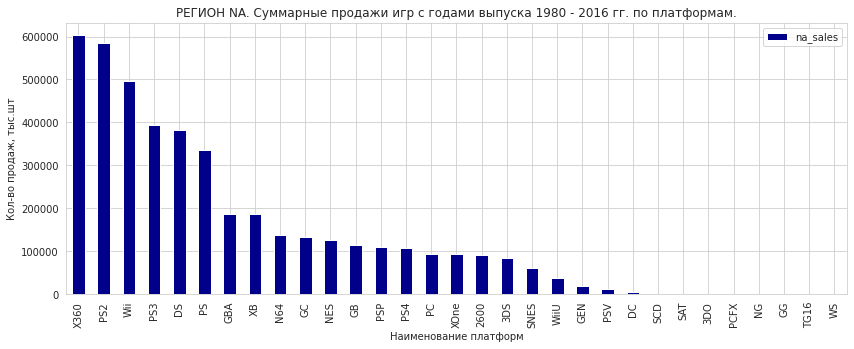

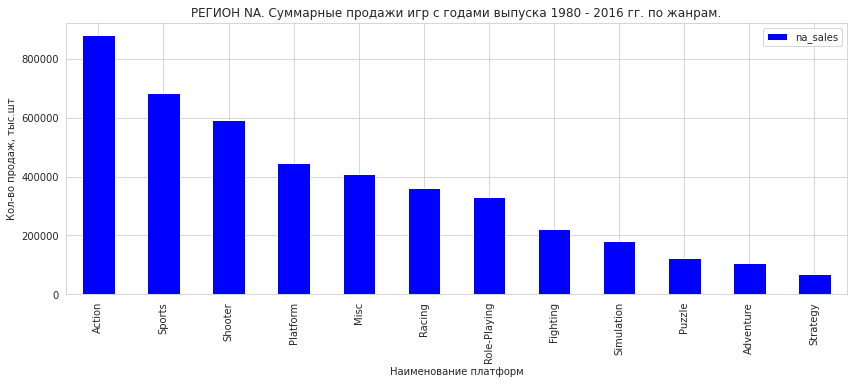

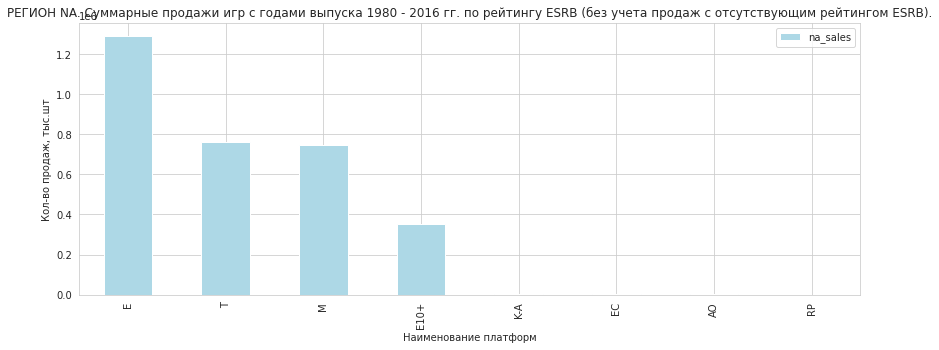

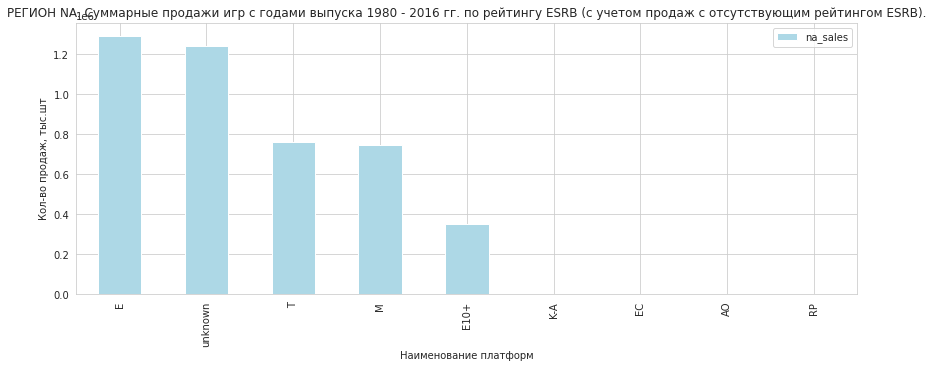

In [13]:
# -------------Регион NA---------------
# Самые популярные платформы (топ-5)
# построим сводную таблицу суммарных продаж в регион NA в зависимости от платформы и соответствующий ей график
data.pivot_table(index=['platform'], values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по платформам.', xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "darkblue", figsize=(14, 5));

data_NA = data.pivot_table(index=['platform'], values='na_sales', aggfunc='sum').\
                            sort_values('na_sales', ascending=False).reset_index()
NA_total = data_NA['na_sales'].sum()
data_NA['ratio_perc'] = round(data_NA['na_sales']/NA_total, 2)*100
display('РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам:', data_NA.head())

# Самые популярные жанры (топ-5)
# построим сводную таблицу суммарных продаж в регион NA в зависимости от жанра и соответствующий ей график
data.pivot_table(index=['genre'], values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам.', \
     xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "blue", figsize=(14, 5));

data_NA = data.pivot_table(index=['genre'], values='na_sales', aggfunc='sum').\
                          sort_values('na_sales', ascending=False).reset_index()
NA_total = data_NA['na_sales'].sum()
data_NA['ratio_perc'] = round(data_NA['na_sales']/NA_total, 2)*100
display('РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам:', data_NA.head())

# Самые популярные группы (топ-5) по рейтингу ESRB
# построим сводную таблицу суммарных продаж в регион NA в зависимости от рейтинга ESRB и соответствующий ей график
# без учета продаж с отсутствующим рейтингом ESRB
data.pivot_table(index=['rating'], values='na_sales', aggfunc='sum').query('rating != "unknown"').\
sort_values('na_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по рейтингу ESRB (без учета продаж с отсутствующим рейтингом ESRB).', xlabel='Наименование платформ', \
     ylabel='Кол-во продаж, тыс.шт', color = "lightblue", figsize=(14, 5));

data_NA = data.pivot_table(index=['rating'], values='na_sales', aggfunc='sum').\
      query('rating != "unknown"').sort_values('na_sales', ascending=False).reset_index()
NA_total = data_NA['na_sales'].sum()
data_NA['ratio_perc'] = round(data_NA['na_sales']/NA_total, 2)*100
display('РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB \
(без учета продаж с отсутствующим рейтингом ESRB):', data_NA.head())

# ............ с учетом продаж с отсутствующим рейтингом ESRB
data.pivot_table(index=['rating'], values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по рейтингу ESRB (с учетом продаж с отсутствующим рейтингом ESRB).', xlabel='Наименование платформ', \
     ylabel='Кол-во продаж, тыс.шт', color = "lightblue", figsize=(14, 5));

data_NA = data.pivot_table(index=['rating'], values='na_sales', aggfunc='sum').\
sort_values('na_sales', ascending=False).reset_index()

NA_total = data_NA['na_sales'].sum()
data_NA['ratio_perc'] = round(data_NA['na_sales']/NA_total, 2)*100
display('РЕГИОН NA. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB \
(с учетом продаж с отсутствующим рейтингом ESRB):', data_NA.head())

#### Регион ЕA ####
**Самые популярные платформы (топ-5)** 
В Европе, как видно из Топ-5, картина несколько иная. PS2, PS3 делят 1-2 места (по 1/7 части рынка), X360 вместе с Wii разделили 3-4 места (по 1/9 части рынка), PS замыкает топ-5.  
В разделе 5.4 представлены топ-5 платформ за актуальный период 2013-2016гг. Топ-5 за актуальный период - (PS4, PS3, XOne, X360, 3DS). Разница существенная. Количественные характеристики представлены в разделе 5.4.  
**Самые популярные жанры**  
ТОП-5 жанров в Европе - (Action, Sports, Shooter, Racing, Misc). Тройка самых популярных жанров в Европе та же самая. Отличия начинаются после третьего места, что видно из Топ-5 жанров, а еще лучше из диаграммы.  
В разделе 5.5 представлены топ-5 жанров за актуальный период 2013-2016гг. Топ-5 за актуальный период - (Action, Shooter, Sports, Role-Playing, Racing). В первой тройке отличия несущественные, на 4-ое место выскочил Role-Playing, а Racing откатился на 5-ое место.  
**Самые популярные группы по рейтингу ESRB**  
По итогам продаж игр с годами выпуска 1980-2016 по рейтингу ESRB - (E, M, T, E10+, AO) в Европе самые популярные также универсальные игры для всех. А на 2-ое место выбились игры для взрослых. Игры для подростков уже отстали. Подробнее на диаграмме.  
В разделе 5.6 представлен ТОП-5 по рейтингу ESRB за актуальный период 2013-2016гг - (M, E, E10+, T). Видны некоторые изменения - игры для взрослых со 2-го места поднялись на 1-ое, универсальные для всех сдали позиции до 2-го места, игры для детей 10+ поднялись с 4-го на 3-е, появились на 4-ом месте игры для подростков.
Однако с учетом того, что пропуски в рейтинге ESRB составляют более 40%, понятно, что сделанные выводы достаточно относительны. Анализ с учетом отсутствующих рейтингов (см.раздел 5.6.2) показывает, что продажи игр с отсутствующим рейтингом уверенно занимают третье место в Европе в Топ-5 продаж по рейтингу ESRB.

'РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам:'

,platform,eu_sales,ratio_perc
0,PS2,339289,14.0
1,PS3,330289,14.0
2,X360,270760,11.0
3,Wii,262209,11.0
4,PS,213610,9.0


'РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам:'

,genre,eu_sales,ratio_perc
0,Action,519128,21.0
1,Sports,376789,16.0
2,Shooter,317339,13.0
3,Racing,236509,10.0
4,Misc,212740,9.0


'РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг.по рейтингу ESRB(без учета продаж с отсутствующим рейтингом ESRB):'

,rating,eu_sales,ratio_perc
0,E,710248,39.0
1,M,483968,27.0
2,T,427030,24.0
3,E10+,188520,10.0
4,AO,610,0.0


'РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг.по рейтингу ESRB(с учетом продаж с отсутствующим рейтингом ESRB):'

,rating,eu_sales,ratio_perc
0,E,710248,29.0
1,unknown,613299,25.0
2,M,483968,20.0
3,T,427030,18.0
4,E10+,188520,8.0


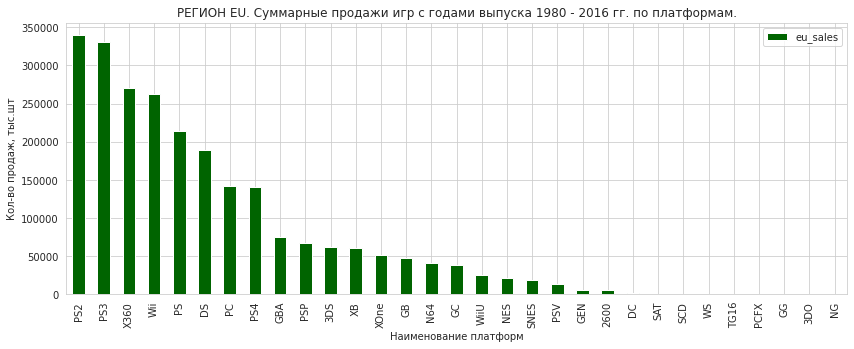

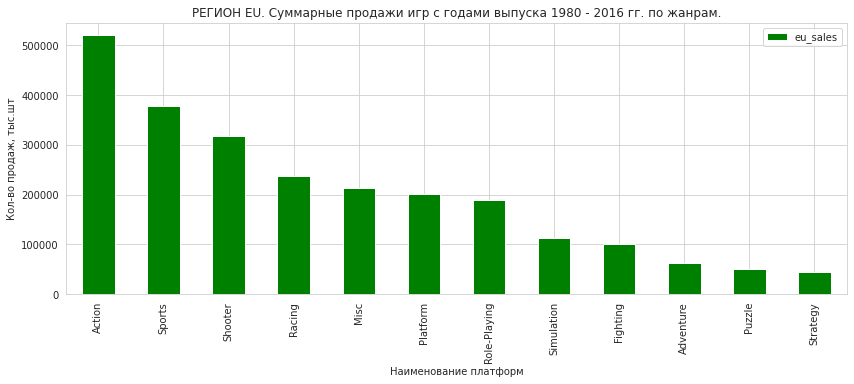

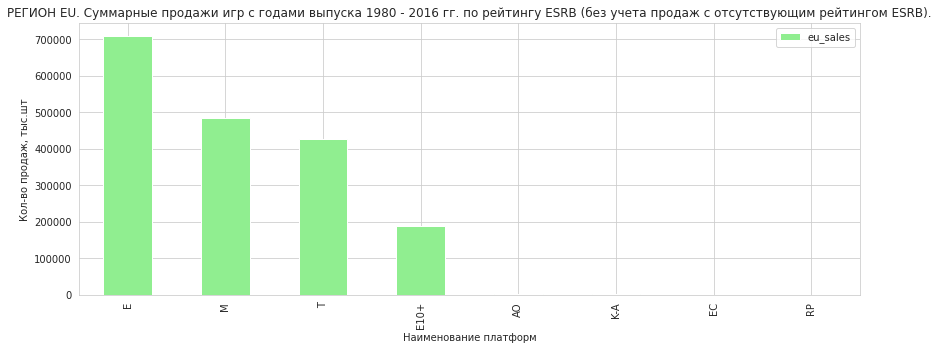

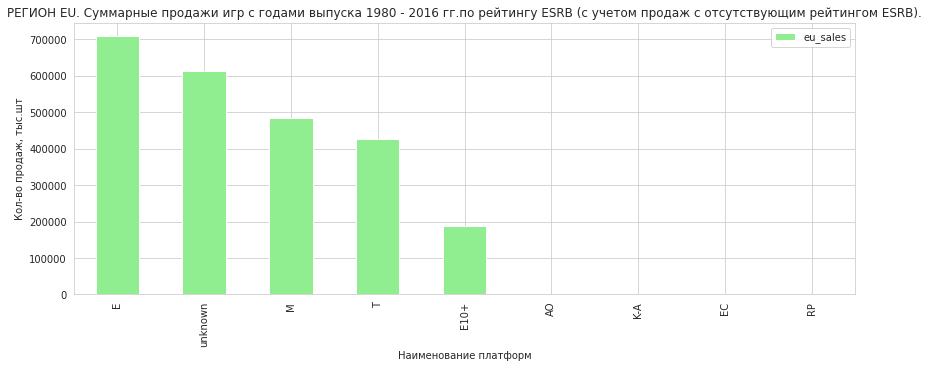

In [14]:
# -------------Регион ЕU---------------
# Самые популярные платформы (топ-5)
# построим сводную таблицу суммарных продаж в регион EU в зависимости от платформы и соответствующий ей график
data.pivot_table(index=['platform'], values='eu_sales', aggfunc='sum').\
      sort_values('eu_sales', ascending=False).\
      plot(kind='bar', grid=True, title='РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по платформам.', xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "darkgreen", \
        figsize=(14, 5));

data_EU = data.pivot_table(index=['platform'], values='eu_sales', aggfunc='sum').\
      sort_values('eu_sales', ascending=False).reset_index()
EU_total = data_EU['eu_sales'].sum()
data_EU['ratio_perc'] = round(data_EU['eu_sales']/EU_total, 2)*100
display('РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам:', data_EU.head())

# Самые популярные жанры (топ-5)
data.pivot_table(index=['genre'], values='eu_sales', aggfunc='sum').\
      sort_values('eu_sales', ascending=False).\
      plot(kind='bar', grid=True, title='РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по жанрам.', xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "green", \
           figsize=(14, 5));

data_EU = data.pivot_table(index=['genre'], values='eu_sales', aggfunc='sum').\
      sort_values('eu_sales', ascending=False).reset_index()
EU_total = data_EU['eu_sales'].sum()
data_EU['ratio_perc'] = round(data_EU['eu_sales']/EU_total, 2)*100
display('РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам:', data_EU.head())

# Самые популярные группы (топ-5) по рейтингу ESRB
data.pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').\
      query('rating != "unknown"').sort_values('eu_sales', ascending=False).\
      plot(kind='bar', grid=True, title='РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по рейтингу ESRB (без учета продаж с отсутствующим рейтингом ESRB).', \
           xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "lightgreen", figsize=(14, 5));

data_EU = data.pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').\
      query('rating != "unknown"').sort_values('eu_sales', ascending=False).reset_index()
EU_total = data_EU['eu_sales'].sum()
data_EU['ratio_perc'] = round(data_EU['eu_sales']/EU_total, 2)*100
display('РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг.по рейтингу ESRB\
(без учета продаж с отсутствующим рейтингом ESRB):', data_EU.head())

data.pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).\
      plot(kind='bar', grid=True, title='РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг.\
по рейтингу ESRB (с учетом продаж с отсутствующим рейтингом ESRB).', \
           xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "lightgreen", figsize=(14, 5));

data_EU = data.pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').\
sort_values('eu_sales', ascending=False).reset_index()

EU_total = data_EU['eu_sales'].sum()
data_EU['ratio_perc'] = round(data_EU['eu_sales']/EU_total, 2)*100
display('РЕГИОН EU. Суммарные продажи игр с годами выпуска 1980 - 2016 гг.по рейтингу ESRB\
(с учетом продаж с отсутствующим рейтингом ESRB):', data_EU.head())


#### Регион JP ####
**Самые популярные платформы (топ-5)** 
В Японии топ-5 совсем другие платформы, за исключением PS2, которая здесь третья. Вот топ-5:  DS (1/7 часть рынка), PS (1/9 часть рынка), PS2  (1/9 часть рынка), SNES (1/11 часть рынка), 3DS (1/12 часть рынка).  
В разделе 5.4 представлены топ-5 платформ за актуальный период 2013-2016гг. Топ-5 за актуальный период - (3DS, PS3, PSV, PS4, WiiU). Разница существенная. Аутсайдер стал лидером, а все остальные участники первого топ-5, во второй просто не попали. Количественные характеристики представлены в разделе 5.4.  
**Самые популярные жанры**  
Топ-5 по жанрам по результатам продаж игр с годами выпуска 1980-2016 - (Role-Playing, Action, Sports, Platform,	Misc). В Японии жанр Role-Playing с существенным отрывом потеснил Action и Sports. Вероятно, разность культур сказывается. Подробнее на диаграмме.  
В разделе 5.5 представлены топ-5 жанров за актуальный период 2013-2016гг. Топ-5 за актуальный период - (Role-Playing, Action, Misc, Fighting, Shooter). Двойка лидеров не изменилась, Misc с 5-го поднялся на 3-е. В первой тройке отличия несущественные, на 4-ое место выскочил Role-Playing, а Racing откатился на 5-ое место. Sports, Platform выпали вообще из топ-5. Их место заняли Fighting и Shooter.
**Самые популярные группы по рейтингу ESRB**  
Топ-5 по рейтингу ESRB по результатм продаж игр с годами выпуска 1980-2016 - (E, T, M, E10+, K-A). Универсальные игры для всех царствуют и здесь. Но игры для подростков уже заметно обгоняют игры для взрослых игроков.  
В разделе 5.6 представлен ТОП-5 по рейтингу ESRB за актуальный период 2013-2016гг - (T, E, M, E10+). Видны некоторые изменения - игры для подростков со 2-го места поднялись на 1-ое, универсальные для всех сдали позиции до 2-го места, игры для взрослых и детей 10+ уверенно держатся на своих местах 3-ем и 4-ом. 
Однако с учетом того, что пропуски в рейтинге ESRB составляют более 40%, понятно, что сделанные выводы достаточно относительны. Анализ с учетом отсутствующих рейтингов (см.раздел 5.6.2) показывает, что продажи игр с отсутствующим рейтингом не просто лидеры в Японии, а лидеры с 4-кратным запасом.

'РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам:'

,platform,jp_sales,ratio_perc
0,DS,175570,14.0
1,PS,139820,11.0
2,PS2,139200,11.0
3,SNES,116550,9.0
4,3DS,100670,8.0


'РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам:'

,genre,jp_sales,ratio_perc
0,Role-Playing,355410,27.0
1,Action,161430,12.0
2,Sports,135540,10.0
3,Platform,130830,10.0
4,Misc,108110,8.0


'РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB (без учета продаж с отсутствующим рейтингом ESRB):'

,rating,jp_sales,ratio_perc
0,E,198110,44.0
1,T,151400,33.0
2,M,64240,14.0
3,E10+,40200,9.0
4,K-A,1460,0.0


'РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB (с учетом продаж с отсутствующим рейтингом ESRB):'

,rating,jp_sales,ratio_perc
0,unknown,841930,65.0
1,E,198110,15.0
2,T,151400,12.0
3,M,64240,5.0
4,E10+,40200,3.0


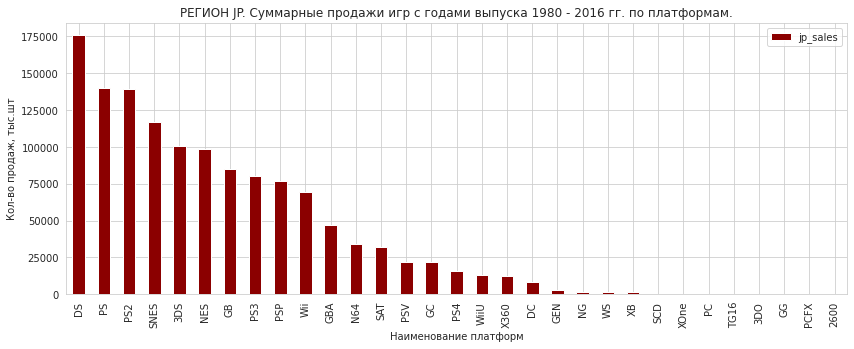

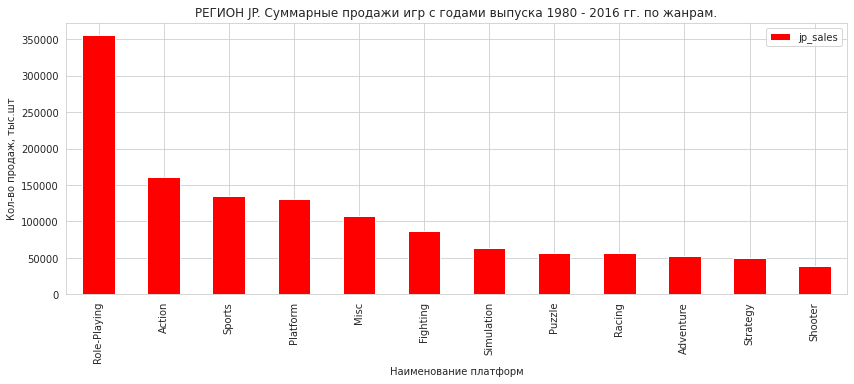

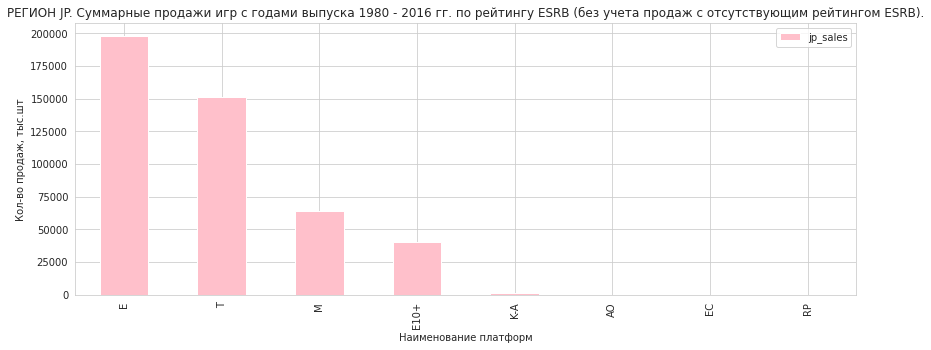

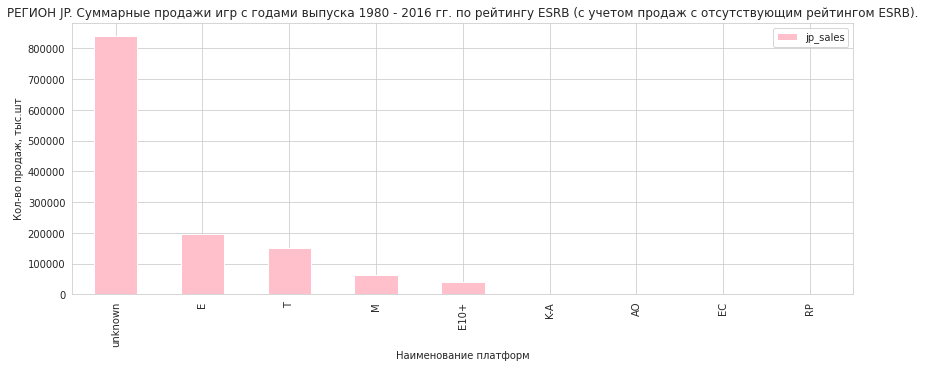

In [15]:
# -------------Регион JP---------------
# Самые популярные платформы (топ-5)
# построим сводную таблицу суммарных продаж в регион JP в зависимости от платформы и соответствующий ей график
data.pivot_table(index=['platform'], values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам.',\
     xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "darkred", figsize=(14, 5));

data_JP = data.pivot_table(index=['platform'], values='jp_sales', aggfunc='sum').\
      sort_values('jp_sales', ascending=False).reset_index()
JP_total = data_JP['jp_sales'].sum()
data_JP['ratio_perc'] = round(data_JP['jp_sales']/JP_total, 2)*100
display('РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по платформам:', data_JP.head())

# Самые популярные жанры (топ-5)
data.pivot_table(index=['genre'], values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам.', \
           xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "red", figsize=(14, 5));

data_JP = data.pivot_table(index=['genre'], values='jp_sales', aggfunc='sum').\
      sort_values('jp_sales', ascending=False).reset_index()
JP_total = data_JP['jp_sales'].sum()
data_JP['ratio_perc'] = round(data_JP['jp_sales']/JP_total, 2)*100
display('РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по жанрам:', data_JP.head())

# Самые популярные группы (топ-5) по рейтингу ESRB
data.pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').\
      query('rating != "unknown"').sort_values('jp_sales', ascending=False).\
      plot(kind='bar', grid=True, title='РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по рейтингу ESRB (без учета продаж с отсутствующим рейтингом ESRB).', \
           xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "pink", figsize=(14, 5));

data_JP = data.pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').\
      query('rating != "unknown"').sort_values('jp_sales', ascending=False).reset_index()
JP_total = data_JP['jp_sales'].sum()
data_JP['ratio_perc'] = round(data_JP['jp_sales']/JP_total, 2)*100
display('РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB \
(без учета продаж с отсутствующим рейтингом ESRB):', data_JP.head())

data.pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).\
plot(kind='bar', grid=True, title='РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. \
по рейтингу ESRB (с учетом продаж с отсутствующим рейтингом ESRB).', \
           xlabel='Наименование платформ', ylabel='Кол-во продаж, тыс.шт', color = "pink", figsize=(14, 5));

data_JP = data.pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').\
sort_values('jp_sales', ascending=False).reset_index()

JP_total = data_JP['jp_sales'].sum()
data_JP['ratio_perc'] = round(data_JP['jp_sales']/JP_total, 2)*100
display('РЕГИОН JP. Суммарные продажи игр с годами выпуска 1980 - 2016 гг. по рейтингу ESRB \
(с учетом продаж с отсутствующим рейтингом ESRB):', data_JP.head())



#### ТОП-5 Платформы. #### 
Создадим раздел представления полученных результатов. Здесь представлены ТОП-5 платформ по продажам игр актуального периода выпуска 2013-2016гг в виде списков, таблиц с указанием платформ и соответствующих им суммами продаж в натуральных единицах тыс.шт., столбчатых графиков. Платформы, не вошедшие в ТОП-5, объединены в одну группу "other" и представлены общей суммой реализованных экземпляров.


ТОП-5 платформ в регионе Северная Америка (NA): ['PS4', 'XOne', 'X360', 'PS3', '3DS']
ТОП-5 платформ в регионе Европа (EU): ['PS4', 'PS3', 'XOne', 'X360', '3DS']
ТОП-5 платформ в регионе Япония (JP): ['3DS', 'PS3', 'PSV', 'PS4', 'WiiU']


'ТОП-5 платформ в регионе Северная Америка (NA):'

,platform,na_sales
0,PS4,108740
1,XOne,93120
2,X360,81660
3,PS3,63499
4,3DS,38200
5,other,52490


'ТОП-5 платформ в регионе Европа (EU):'

,platform,eu_sales
0,PS4,141090
1,PS3,67810
2,XOne,51590
3,X360,42520
4,3DS,30960
5,other,58260


'ТОП-5 платформ в регионе Япония (JP):'

,platform,jp_sales
0,3DS,67810
1,PS3,23350
2,PSV,18590
3,PS4,15960
4,WiiU,10880
5,other,4190


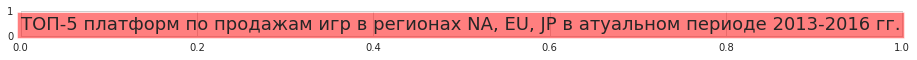

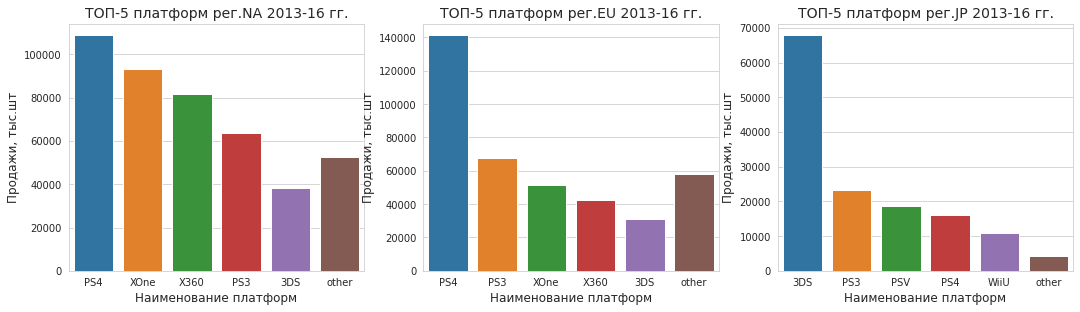

In [16]:
# сформируем срез продаж Сев.Америки актуального периода 2013-2016
NA_platf_act_per = data.query('year_of_release > 2012').pivot_table(index=['platform'], values='na_sales', aggfunc='sum').\
                            sort_values('na_sales', ascending=False).reset_index().copy()
# сформируем срез продаж Европы актуального периода 2013-2016
EU_platf_act_per = data.query('year_of_release > 2012').pivot_table(index=['platform'], values='eu_sales', aggfunc='sum').\
                            sort_values('eu_sales', ascending=False).reset_index().copy()
# сформируем срез продаж Японии актуального периода 2013-2016
JP_platf_act_per = data.query('year_of_release > 2012').pivot_table(index=['platform'], values='jp_sales', aggfunc='sum').\
                            sort_values('jp_sales', ascending=False).reset_index().copy()

# выведем список ТОП-5 платформ по срезу продаж Сев.Америки актуального периода 2013-2016
list_top5_NA_platf_act_per = list(NA_platf_act_per['platform'].head())
print('ТОП-5 платформ в регионе Северная Америка (NA):', list_top5_NA_platf_act_per)
# выведем список ТОП-5 платформ по срезу продаж Европы актуального периода 2013-2016
list_top5_EU_platf_act_per = list(EU_platf_act_per['platform'].head())
print('ТОП-5 платформ в регионе Европа (EU):', list_top5_EU_platf_act_per)
# выведем список ТОП-5 платформ по срезу продаж Японии актуального периода 2013-2016
list_top5_JP_platf_act_per = list(JP_platf_act_per['platform'].head())
print('ТОП-5 платформ в регионе Япония (JP):', list_top5_JP_platf_act_per)

# вычислим сумму продаж по платформам не вошедшим в ТОП-5
na = 0
for i in range(5,len(NA_platf_act_per['na_sales'])):
    na += NA_platf_act_per.loc[i,'na_sales']
eu = 0
for i in range(5,len(EU_platf_act_per['eu_sales'])):
    eu += EU_platf_act_per.loc[i,'eu_sales']
jp = 0
for i in range(5,len(JP_platf_act_per['jp_sales'])):
    jp += JP_platf_act_per.loc[i,'jp_sales']
    
# удалим строки ниже шестой (индекс=5)   
NA_platf_act_per = NA_platf_act_per.loc[0:5, :]
EU_platf_act_per = EU_platf_act_per.loc[0:5, :]
JP_platf_act_per = JP_platf_act_per.loc[0:5, :]

# шестой строке присвоим значение 'platform'[5]='other' и 'na_sales'[5]=сумма отброшенных строк
NA_platf_act_per['platform'][5] = 'other'
NA_platf_act_per['na_sales'][5] = na
display('ТОП-5 платформ в регионе Северная Америка (NA):', NA_platf_act_per)
EU_platf_act_per['platform'][5] = 'other'
EU_platf_act_per['eu_sales'][5] = eu
display('ТОП-5 платформ в регионе Европа (EU):', EU_platf_act_per)
JP_platf_act_per['platform'][5] = 'other'
JP_platf_act_per['jp_sales'][5] = jp
display('ТОП-5 платформ в регионе Япония (JP):', JP_platf_act_per)

# задаем первую строку из одного столбца
plt.figure(figsize=(15.8,1))
plt.subplot(2, 1, 1)
plt.text(0.0, 0.25, 'ТОП-5 платформ по продажам игр в регионах NA, EU, JP в атуальном периоде 2013-2016 гг.',\
        bbox=dict(facecolor='red', alpha=0.5), fontsize=18, horizontalalignment='left') 
# задаем вторую строку из трех столбцов
plt.figure(figsize=(18,10))
axNA = plt.subplot(2,3,1)
plt.grid
sns.barplot(x="platform", y="na_sales", data=NA_platf_act_per)
plt.title('ТОП-5 платформ рег.NA 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

axEU = plt.subplot(2,3,2)
sns.barplot(x="platform", y="eu_sales", data=EU_platf_act_per)
plt.title('ТОП-5 платформ рег.EU 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

axJP = plt.subplot(2,3,3)
sns.barplot(x="platform", y="jp_sales", data=JP_platf_act_per)
plt.title('ТОП-5 платформ рег.JP 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование платформ', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

plt.show()


#### ТОП-5 Жанры. #### 
Создадим раздел представления полученных результатов. Здесь представлены ТОП-5 жанров в проданных играх актуального периода выпуска 2013-2016гг в виде списков, таблиц с указанием жанров и соответствующих им суммами продаж в натуральных единицах тыс.шт., столбчатых графиков. Жанры, не вошедшие в ТОП-5, объединены в одну группу "other" и представлены общей суммой реализованных экземпляров.

ТОП-5 жанров в регионе Северная Америка (NA): ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc']
ТОП-5 жанров в регионе Европа (EU): ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']
ТОП-5 жанров в регионе Япония (JP): ['Role-Playing', 'Action', 'Misc', 'Fighting', 'Shooter']


'ТОП-5 жанров в регионе Северная Америка (NA):'

,genre,na_sales
0,Action,126050
1,Shooter,109740
2,Sports,65270
3,Role-Playing,46400
4,Misc,27489
5,other,62760


'ТОП-5 жанров в регионе Европа (EU):'

,genre,eu_sales
0,Action,118130
1,Shooter,87860
2,Sports,60520
3,Role-Playing,36970
4,Racing,20190
5,other,68560


'ТОП-5 жанров в регионе Япония (JP):'

,genre,jp_sales
0,Role-Playing,51040
1,Action,40490
2,Misc,9200
3,Fighting,7650
4,Shooter,6610
5,other,25790


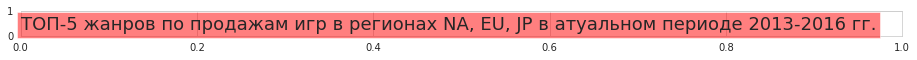

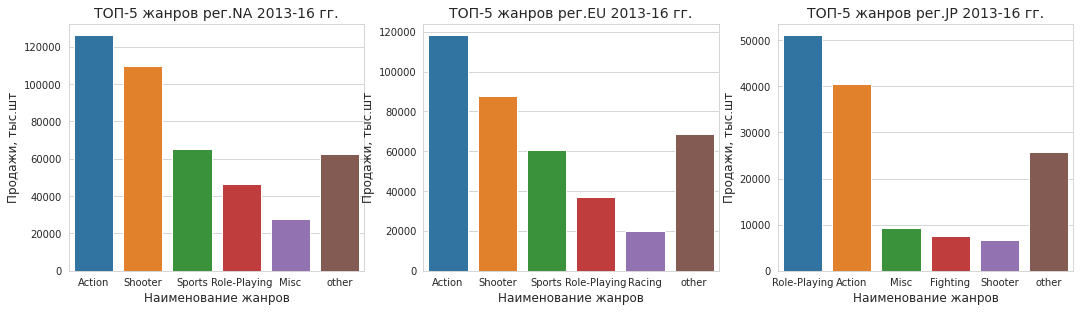

In [17]:
# сформируем срез продаж Сев.Америки актуального периода 2013-2016
NA_genre_act_per = data.query('year_of_release > 2012').pivot_table(index=['genre'], values='na_sales', aggfunc='sum').\
                            sort_values('na_sales', ascending=False).reset_index().copy()
# сформируем срез продаж Европы актуального периода 2013-2016
EU_genre_act_per = data.query('year_of_release > 2012').pivot_table(index=['genre'], values='eu_sales', aggfunc='sum').\
                            sort_values('eu_sales', ascending=False).reset_index().copy()
# сформируем срез продаж Японии актуального периода 2013-2016
JP_genre_act_per = data.query('year_of_release > 2012').pivot_table(index=['genre'], values='jp_sales', aggfunc='sum').\
                            sort_values('jp_sales', ascending=False).reset_index().copy()

# выведем список ТОП-5 жанров по срезу продаж Сев.Америки актуального периода 2013-2016
list_top5_NA_genre_act_per = list(NA_genre_act_per['genre'].head())
print('ТОП-5 жанров в регионе Северная Америка (NA):', list_top5_NA_genre_act_per)
# выведем список ТОП-5 жанров по срезу продаж Европы актуального периода 2013-2016
list_top5_EU_genre_act_per = list(EU_genre_act_per['genre'].head())
print('ТОП-5 жанров в регионе Европа (EU):', list_top5_EU_genre_act_per)
# выведем список ТОП-5 жанров по срезу продаж Японии актуального периода 2013-2016
list_top5_JP_genre_act_per = list(JP_genre_act_per['genre'].head())
print('ТОП-5 жанров в регионе Япония (JP):', list_top5_JP_genre_act_per)

# вычислим сумму продаж по жанрам не вошедшим в ТОП-5
na = 0
for i in range(5,len(NA_genre_act_per['na_sales'])):
    na += NA_genre_act_per.loc[i,'na_sales']
eu = 0
for i in range(5,len(EU_genre_act_per['eu_sales'])):
    eu += EU_genre_act_per.loc[i,'eu_sales']
jp = 0
for i in range(5,len(JP_genre_act_per['jp_sales'])):
    jp += JP_genre_act_per.loc[i,'jp_sales']
    
# удалим строки ниже шестой (индекс=5)   
NA_genre_act_per = NA_genre_act_per.loc[0:5, :]
EU_genre_act_per = EU_genre_act_per.loc[0:5, :]
JP_genre_act_per = JP_genre_act_per.loc[0:5, :]

# шестой строке присвоим значение 'genre'[5]='other' и 'na_sales'[5]=сумма отброшенных строк
NA_genre_act_per['genre'][5] = 'other'
NA_genre_act_per['na_sales'][5] = na
display('ТОП-5 жанров в регионе Северная Америка (NA):', NA_genre_act_per)
EU_genre_act_per['genre'][5] = 'other'
EU_genre_act_per['eu_sales'][5] = eu
display('ТОП-5 жанров в регионе Европа (EU):', EU_genre_act_per)
JP_genre_act_per['genre'][5] = 'other'
JP_genre_act_per['jp_sales'][5] = jp
display('ТОП-5 жанров в регионе Япония (JP):', JP_genre_act_per)

# задаем первую строку из одного столбца
plt.figure(figsize=(15.8,1))
plt.subplot(2, 1, 1)
plt.text(0.0, 0.25, 'ТОП-5 жанров по продажам игр в регионах NA, EU, JP в атуальном периоде 2013-2016 гг.',\
        bbox=dict(facecolor='red', alpha=0.5), fontsize=18, horizontalalignment='left') 
# задаем вторую строку из трех столбцов
plt.figure(figsize=(18,10))
axNA = plt.subplot(2,3,1)
plt.grid
sns.barplot(x="genre", y="na_sales", data=NA_genre_act_per)
plt.title('ТОП-5 жанров рег.NA 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование жанров', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

axEU = plt.subplot(2,3,2)
sns.barplot(x="genre", y="eu_sales", data=EU_genre_act_per)
plt.title('ТОП-5 жанров рег.EU 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование жанров', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

axJP = plt.subplot(2,3,3)
sns.barplot(x="genre", y="jp_sales", data=JP_genre_act_per)
plt.title('ТОП-5 жанров рег.JP 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование жанров', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

plt.show()

#### ТОП-5 по рейтингу ESRB. #### 
##### Без учета пропусков #####
Создадим раздел представления полученных результатов. Здесь представлены ТОП-5 по рейтингу ESRB (без учет пропусков) в проданных играх актуального периода выпуска 2013-2016гг в виде списков, таблиц с указанием рейтинга и соответствующих им суммами продаж в натуральных единицах тыс.шт., столбчатых графиков  
В Северной Америке и Европе распределение по рейтингу совершенно аналогичные - (M, E, E10+, T), в лидерах игры для взрослых игроков, затем универсальные для всех, третьи - для детей старше 10 лет и замыкают игры для подростков.  
В Японии заметно иная картина - (T, E, M, E10+). В лидерах игры для подростков, затем универсальные, только третьи игры для взрослых и замыкают игры для детей 10+.  
Однако, эти рейтинги достаточно относительны, поскольку, как показано в следующем разделе, очень велика в данных доля продаж игр с неизвестным рейтингом ESRB. 

ТОП-5 по рейтингу ESRB без учета пропусков в регионе Северная Америка (NA): ['M', 'E', 'E10+', 'T']
ТОП-5 по рейтингу ESRB без учета пропусков в регионе Европа (EU): ['M', 'E', 'E10+', 'T']
ТОП-5 по рейтингу ESRB без учета пропусков в регионе Япония (JP): ['T', 'E', 'M', 'E10+']


'ТОП-5 по рейтингу ESRB без учета пропусков в регионе Северная Америка (NA):'

,rating,na_sales
0,M,165210
1,E,79050
2,E10+,54240
3,T,49790


'ТОП-5 по рейтингу ESRB без учета пропусков в регионе Европа (EU):'

,rating,eu_sales
0,M,145320
1,E,83360
2,E10+,42690
3,T,41950


'ТОП-5 по рейтингу ESRB без учета пропусков в регионе Япония (JP):'

,rating,jp_sales
0,T,20590
1,E,15140
2,M,14110
3,E10+,5890


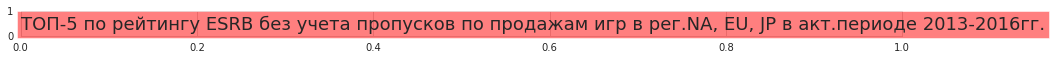

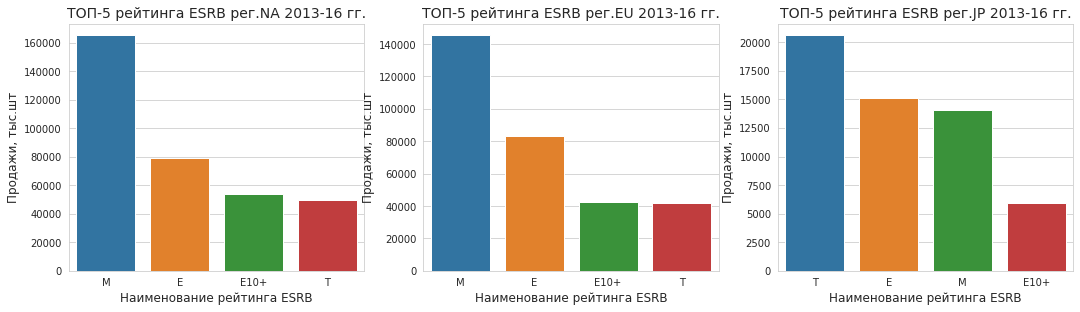

In [18]:
# сформируем по рейтингу ESRB без учета пропусков срез продаж Сев.Америки актуального периода 2013-2016
NA_rating_act_per = data.query('year_of_release > 2012 and rating != "unknown"').\
pivot_table(index=['rating'], values='na_sales', aggfunc='sum').\
sort_values('na_sales', ascending=False).reset_index().copy()
# сформируем по рейтингу ESRB без учета пропусков срез продаж Европы актуального периода 2013-2016
EU_rating_act_per = data.query('year_of_release > 2012 and rating != "unknown"').\
pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').\
sort_values('eu_sales', ascending=False).reset_index().copy()
# сформируем по рейтингу ESRB без учета пропусков срез продаж Японии актуального периода 2013-2016
JP_rating_act_per = data.query('year_of_release > 2012 and rating != "unknown"').\
pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').\
sort_values('jp_sales', ascending=False).reset_index().copy()

# выведем список ТОП-5 рейтинга ESRB по срезу продаж Сев.Америки актуального периода 2013-2016
list_top5_NA_rating_act_per = list(NA_rating_act_per['rating'].head())
print('ТОП-5 по рейтингу ESRB без учета пропусков в регионе Северная Америка (NA):', list_top5_NA_rating_act_per)
# выведем список ТОП-5 рейтинга ESRB по срезу продаж Европы актуального периода 2013-2016
list_top5_EU_rating_act_per = list(EU_rating_act_per['rating'].head())
print('ТОП-5 по рейтингу ESRB без учета пропусков в регионе Европа (EU):', list_top5_EU_rating_act_per)
# выведем список ТОП-5 рейтинга ESRB по срезу продаж Японии актуального периода 2013-2016
list_top5_JP_rating_act_per = list(JP_rating_act_per['rating'].head())
print('ТОП-5 по рейтингу ESRB без учета пропусков в регионе Япония (JP):', list_top5_JP_rating_act_per)

display('ТОП-5 по рейтингу ESRB без учета пропусков в регионе Северная Америка (NA):', NA_rating_act_per)
display('ТОП-5 по рейтингу ESRB без учета пропусков в регионе Европа (EU):', EU_rating_act_per)
display('ТОП-5 по рейтингу ESRB без учета пропусков в регионе Япония (JP):', JP_rating_act_per)

# задаем первую строку из одного столбца
plt.figure(figsize=(15.8,1))
plt.subplot(2, 1, 1)
plt.text(0.0, 0.25, 'ТОП-5 по рейтингу ESRB без учета пропусков по продажам игр в рег.NA, EU, JP в акт.периоде 2013-2016гг.',\
        bbox=dict(facecolor='red', alpha=0.5), fontsize=18, horizontalalignment='left') 
# задаем вторую строку из трех столбцов
plt.figure(figsize=(18,10))
axNA = plt.subplot(2,3,1)
plt.grid
sns.barplot(x="rating", y="na_sales", data=NA_rating_act_per)
plt.title('ТОП-5 рейтинга ESRB рег.NA 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование рейтинга ESRB', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

axEU = plt.subplot(2,3,2)
sns.barplot(x="rating", y="eu_sales", data=EU_rating_act_per)
plt.title('ТОП-5 рейтинга ESRB рег.EU 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование рейтинга ESRB', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

axJP = plt.subplot(2,3,3)
sns.barplot(x="rating", y="jp_sales", data=JP_rating_act_per)
plt.title('ТОП-5 рейтинга ESRB рег.JP 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование рейтинга ESRB', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

plt.show()

##### С учетом пропусков #####
Представлены данные по распределению рейтинга ESRB в проданных играх с учетом того факта, что многие продажи относятся к играм у которых не известен рейтинг. 
В Северной Америке продажи игр с неизвестным рейтингом ESRB на 2-ом месте, в Европе на 3-ем, а в Японии не просто на 1-ом, но и еще с существенным отрывом (более чем в 4 раза) от остальных.

ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Северная Америка (NA): ['M', 'unknown', 'E', 'E10+', 'T']
ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Европа (EU): ['M', 'E', 'unknown', 'E10+', 'T']
ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Япония (JP): ['unknown', 'T', 'E', 'M', 'E10+']


'ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Северная Америка (NA):'

,rating,na_sales
0,M,165210
1,unknown,89419
2,E,79050
3,E10+,54240
4,T,49790


'ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Европа (EU):'

,rating,eu_sales
0,M,145320
1,E,83360
2,unknown,78910
3,E10+,42690
4,T,41950


'ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Япония (JP):'

,rating,jp_sales
0,unknown,85050
1,T,20590
2,E,15140
3,M,14110
4,E10+,5890


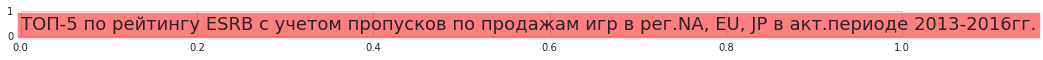

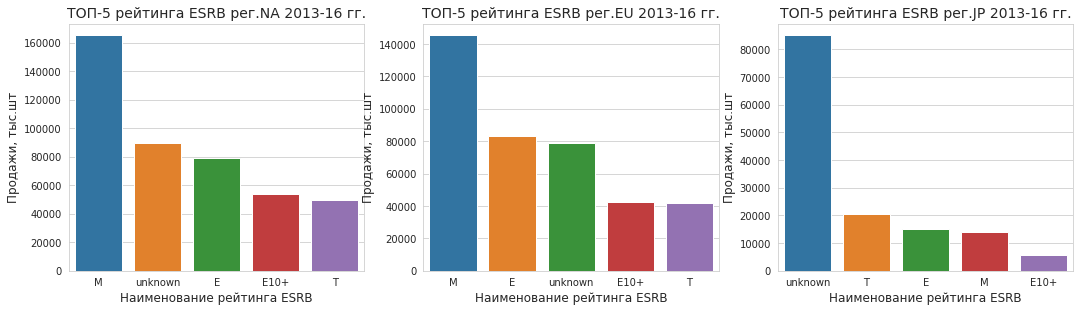

In [19]:
# сформируем по рейтингу ESRB с учетом пропусков срез продаж Сев.Америки актуального периода 2013-2016
NA_rating_act_per = data.query('year_of_release > 2012').\
pivot_table(index=['rating'], values='na_sales', aggfunc='sum').\
sort_values('na_sales', ascending=False).reset_index().copy()
# сформируем по рейтингу ESRB с учетом пропусков срез продаж Европы актуального периода 2013-2016
EU_rating_act_per = data.query('year_of_release > 2012').\
pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').\
sort_values('eu_sales', ascending=False).reset_index().copy()
# сформируем по рейтингу ESRB с учетом пропусков срез продаж Японии актуального периода 2013-2016
JP_rating_act_per = data.query('year_of_release > 2012').\
pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').\
sort_values('jp_sales', ascending=False).reset_index().copy()

# выведем список ТОП-5 рейтинга ESRB по срезу продаж Сев.Америки актуального периода 2013-2016
list_top5_NA_rating_act_per = list(NA_rating_act_per['rating'].head())
print('ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Северная Америка (NA):', list_top5_NA_rating_act_per)
# выведем список ТОП-5 рейтинга ESRB по срезу продаж Европы актуального периода 2013-2016
list_top5_EU_rating_act_per = list(EU_rating_act_per['rating'].head())
print('ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Европа (EU):', list_top5_EU_rating_act_per)
# выведем список ТОП-5 рейтинга ESRB по срезу продаж Японии актуального периода 2013-2016
list_top5_JP_rating_act_per = list(JP_rating_act_per['rating'].head())
print('ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Япония (JP):', list_top5_JP_rating_act_per)

display('ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Северная Америка (NA):', NA_rating_act_per)
display('ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Европа (EU):', EU_rating_act_per)
display('ТОП-5 по рейтингу ESRB с учетом пропусков в регионе Япония (JP):', JP_rating_act_per)

# задаем первую строку из одного столбца
plt.figure(figsize=(15.8,1))
plt.subplot(2, 1, 1)
plt.text(0.0, 0.25, 'ТОП-5 по рейтингу ESRB с учетом пропусков по продажам игр в рег.NA, EU, JP в акт.периоде 2013-2016гг.',\
        bbox=dict(facecolor='red', alpha=0.5), fontsize=18, horizontalalignment='left') 
# задаем вторую строку из трех столбцов
plt.figure(figsize=(18,10))
axNA = plt.subplot(2,3,1)
plt.grid
sns.barplot(x="rating", y="na_sales", data=NA_rating_act_per)
plt.title('ТОП-5 рейтинга ESRB рег.NA 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование рейтинга ESRB', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);

axEU = plt.subplot(2,3,2)
sns.barplot(x="rating", y="eu_sales", data=EU_rating_act_per)
plt.title('ТОП-5 рейтинга ESRB рег.EU 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование рейтинга ESRB', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

axJP = plt.subplot(2,3,3)
sns.barplot(x="rating", y="jp_sales", data=JP_rating_act_per)
plt.title('ТОП-5 рейтинга ESRB рег.JP 2013-16 гг.', fontsize=14) 
plt.xlabel('Наименование рейтинга ESRB', fontsize=12)
plt.ylabel('Продажи, тыс.шт', fontsize=12);
plt.grid

plt.show()

### Гипотезы и их проверка. ###


#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. ####  
**1.** Нулевая гипотеза Н0, которую будем проверять - "Средние пользовательские рейтинги платформ Xbox One и PC равны".  
Альтернативная гипотеза Н1 - "Средние пользовательские рейтинги платформ Xbox One и PC не равны."  
Сформируем выборки data_XOne'user_score' и data_PC'user_score' и воспользуемся методом scipy.stats.ttest_ind() при уровне p-value = 5%. Выбран метод scipy.stats.ttest_ind() по той причине, что сравнивать надо средние значения двух генеральных совокупностей пользовательских оценок двух разных платформ между собой по выборкам из них. Результат проверки представлен, полученный уровень p-value = 0,0005%.  
Таким образом, полученный уровень p-value **при установленном пороге значимости 5% позволяет отклонить нулевую гипотеза Н0  и выбрать альтернативную гипотезу Н1 - "Средние пользовательские рейтинги платформ Xbox One и PC не равны на временном интервале 1980-2016гг."**  
**2.** Нулевая гипотеза Н0 и альтернативная гипотеза Н1 те же самые. Но сформируем выборку data_PC'user_score' за период 2013-2016гг, равный времени существования платформ Xbox One и далее, по-прежнему, воспользуемся методом scipy.stats.ttest_ind() при уровне p-value = 5%. Получаем p-value = 14,8%.  
Таким образом, данное значение p-value **при установленном пороге значимости 5% не позволяет отвергнуть нулевую гипотезу Н0 - "Средние пользовательские рейтинги платформ Xbox One и PC равны на временном интервале 2013-2016гг.".**

In [20]:
# -----XOne------
data_XOne = data.loc[(data['platform'] == 'XOne') & (data['user_score'] != 'unknown')]
data_XOne['user_score'] = data_XOne['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "XOne":', '\n', data_XOne['user_score'].describe(), '\n')

# -----PC------
data_PC = data.loc[(data['platform'] == 'PC') & (data['user_score'] != 'unknown')]
data_PC['user_score'] = data_PC['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "PC":', '\n', data_PC['user_score'].describe(), '\n')

# проверка гипотезы
alpha = 0.05
results = st.ttest_ind(data_XOne['user_score'], data_PC['user_score'], equal_var=False )
print('p-значение:', results.pvalue)

# -----PC------в том же временном интервале, что и XOne
data_PC = data.loc[(data['platform'] == 'PC') & (data['user_score'] != 'unknown') & (data['year_of_release'] > 2012)]
data_PC['user_score'] = data_PC['user_score'].astype('int')
display('Стат.характеристики оценок пользователей игр платформы "PC" во временном интервале 2013-2016гг:', \
        data_PC['user_score'].describe())

results = st.ttest_ind(data_XOne['user_score'], data_PC['user_score'], equal_var=False )
print('p-значение:', results.pvalue)







Стат.характеристики оценок пользователей игр платформы "XOne": 
 count    182.000000
mean      65.214286
std       13.809406
min       16.000000
25%       58.000000
50%       68.000000
75%       75.000000
max       92.000000
Name: user_score, dtype: float64 

Стат.характеристики оценок пользователей игр платформы "PC": 
 count    770.000000
mean      70.624675
std       15.299631
min       14.000000
25%       62.000000
50%       75.000000
75%       82.000000
max       93.000000
Name: user_score, dtype: float64 

p-значение: 4.935072360183449e-06


'Стат.характеристики оценок пользователей игр платформы "PC" во временном интервале 2013-2016гг:'

count    155.000000
mean      62.696774
std       17.423813
min       14.000000
25%       53.000000
50%       68.000000
75%       76.000000
max       93.000000
Name: user_score, dtype: float64

p-значение: 0.1475959401343053


#### Средние пользовательские рейтинги жанров Action и Sports разные.  
Нулевая гипотеза Н0, которую будем проверять - "Средние пользовательские рейтинги жанров Action и Sports равны".  
Альтернативная гипотеза Н1 - "Средние пользовательские рейтинги платформ Xbox One и PC не равны."  
Сформируем выборки data_XOne'user_score' и data_PC'user_score' и воспользуемся методом scipy.stats.ttest_ind() при уровне p-value = 5%. Выбран метод scipy.stats.ttest_ind() по той причине, что сравнивать надо средние значения двух генеральных совокупностей пользовательских оценок двух разных жанров между собой по выборкам из них. Результат проверки представлен, полученный уровень p-value = 11,5%.  
Таким образом, **нулевую гипотезу Н0 при установленном пороге значимости 5% не получилось отвергнуть и выбирается нулевая гипотеза - "Средние пользовательские рейтинги жанров Action и Sports равны."**

In [21]:
# -----Action------
data_Action = data.loc[(data['genre'] == 'Action') & (data['user_score'] != 'unknown')]
data_Action['user_score'] = data_Action['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "XOne":', '\n', data_Action['user_score'].describe(), '\n')

# -----Sports------
data_Sports = data.loc[(data['genre'] == 'Sports') & (data['user_score'] != 'unknown')]
data_Sports['user_score'] = data_Sports['user_score'].astype('int')
print('Стат.характеристики оценок пользователей игр платформы "PC":', '\n', data_Sports['user_score'].describe(), '\n')

# проверка гипотезы
alpha = 0.05
results = st.ttest_ind(data_Action['user_score'], data_Sports['user_score'], equal_var=False )
print('p-значение:', results.pvalue)



Стат.характеристики оценок пользователей игр платформы "XOne": 
 count    1830.000000
mean       70.540437
std        14.253936
min         3.000000
25%        63.000000
50%        74.000000
75%        81.000000
max        95.000000
Name: user_score, dtype: float64 

Стат.характеристики оценок пользователей игр платформы "PC": 
 count    1103.000000
mean       69.611967
std        16.113704
min         2.000000
25%        61.000000
50%        74.000000
75%        81.000000
max        95.000000
Name: user_score, dtype: float64 

p-значение: 0.1148381879149927


### Общий вывод. ###


Проведен анализ исторических (до 2016 года) данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах. 

Были проведена следующая работа:
- изучены файлы, 
- проведена предообработка данных 
    - определены и обработаны пропуски
    - устранены явные и неявные дубликаты
    - скорректированы типы данных
    - переименованы столбцы
    - проверено наличие явных и неявных дубликатов
- рассчитан и добавлен новый столбец с суммой продаж по трем регионам 
- проведен исследовательский анализ данных:
    - количество выпущенных игр в различные годы
    - изучены продажи различных платформ за представленный исторический период и составлен рейтинг
    - определено характерное "время жизни" платформы и актуальное время наблюдения
    - изучены продажи игр в зависимости от года выпуска этих игр
    - изучена ситуация актуального периода и выработаны заключения и рекомендации для прогноза на 2017 год
    - изучено влияние отзывов экспертов и пользователей на показатели реализации игр
    - изучено распределение объёмов продаваемых игр по жанрам
    - проведен сравнительный анализ особенностей региональных рынков игр Северной Америки, Европы и Японии
    - проведена проверка гипотез о средних пользовательских рейтингах для двух платформ и двух жанров
    
По результатам анализа можно сделать следующие выводы:
- производство платформенных игр прогрессирующе росло с начала 90-х годов до 2009 года, затем начался спад и резкий обвал в 2011 году с дальнейшим медленным спадом в 2013-2016 годах на уровне 38-35%% от максимума 2009 года
- топ-5 платформ по производству и продажам игр за период наблюдения 1980-2016гг образуют следующие платформы (PS2, X360, Wii, PS3, DS); за актуальный период 2013-2016гг топ-5 платформ - (PS4, PS3, XOne, 3DS, X360)
- характерное "время жизни" платформы, по уровню 25млн.экз.(14-18%% от максимальной реализации) - 7-9 лет, по уровню 50 млн.экз. (29-36%% от максимальной реализации) - 5-7 лет
- в качестве актуального срока для прогноза можно взять срок полупериода "времени жизни" 3-4 года от года выпуска игры
- рынок продаж платформенных игр аналогично производству рос до 2008-2009 годов выпуска, затем спад на играх 2010-2011 годов выпуска и обвал, но не настолько глубокий как в выпуске игр, и далее фиксация уровня на играх 2012-2013 годов выпуска и затем нарастающий спад на играх 2014-2016 годов выпуска
- в период 2013-2016 годов выпуска игр, актуальный для прогноза на 2017 год, рынок платформенных игр находится в ситуации спада, все наличествующие платформы в состоянии угасания. При экстраполяции близкой к линейной некоторые перспективы на 2017 год есть только у платформ PS4 на уровне 25-30 млн.экз., XOne - 10-12 млн.экз., 3DS - 5-7 млн.экз. К этой группе можно добавить также платформу РС на уровне 1,5-2 млн.экз., поскольку компьютерные игры были, есть и, хоть рекордов не били, держались в голове второго десятка, - и будут. Рекомендуется оставить под наблюдением платформы Wii и PS3, по которым не удалось сделать однозначный вывод из-за недостатка данных по продажам.
- сделан вывод о том, что оценки пользователей и экспертов не оказывают заметного влияния на объемы продаж платформенных игр; при одинаковых рейтингах объёмы продаж могут отличаться в десятки раз
- по регионам получены следующие обобщающие данные:
- - по данным продаж за период выпуска игр 1980-2016гг
- - - Северная Америка
          топ-3 платформ - X360, PS2, Wii
          топ-3 жанров - Action, Sports и Shooter
          топ-3 групп ESRB - Е (для всех), Т (подростки)и М (взрослые) делят 2-3 места без учета игр с неизвестным рейтингом ESRB, с учетом - Е, "unknown", Т
- - - Европа
          топ-3 платформ - PS2, PS3 делят 1-2 места, X360 вместе с Wii делят 3-4 места 
          топ-3 жанров - Action, Sports и Shooter
          топ-3 групп ESRB - Е (для всех), М (взрослые), Т (подростки) без учета игр с неизвестным рейтингом ESRB, с учетом - Е, "unknown", М
- - - Япония
          топ-3 платформ - DS, PS, PS2 
          топ-3 жанров - Role-Playing, Action, Sports
          топ-3 групп ESRB - Е (для всех), М (взрослые), Т (подростки) без учета игр с неизвестным рейтингом ESRB, с учетом - "unknown", Е, , М
- - по данным продаж за актульный период выпуска игр 2013-2016гг
- - - Северная Америка
          топ-3 платформ - PS4, XOne, X360
          топ-3 жанров - Action, Shooter, Sports
          топ-3 групп ESRB - M, E, E10+ без учета игр с неизвестным рейтингом ESRB, с учетом - M, "unknown", E
- - - Европа
          топ-3 платформ - PS4, PS3, XOne
          топ-3 жанров - Action, Shooter, Sports
          топ-3 групп ESRB - M, E, E10+ без учета игр с неизвестным рейтингом ESRB, с учетом - M, E, "unknown"
- - - Япония
          топ-3 платформ - 3DS, PS3, PSV 
          топ-3 жанров - Role-Playing, Action, Misc
          топ-3 групп ESRB - T, E, M без учета игр с неизвестным рейтингом ESRB, с учетом - "unknown", T, E, причем "unknown" лидируют с 4-кратным запасом
- из приведенных выше данных видно, что если топ-3 платформ за разные периоды выпуска игр существенно отличаются, то жанры и рейтинги ESRB значительно более устойчивы и консервативны
- по играм жанров Shooter и Sports отмечена специфика продаж, связанная с меньшим количеством фактов продаж, но при этом заметно большим кол-вом экземпляров в одной продаже (больший "средний чек")
- статистическая проверка гипотезы  при уровне значимости 5% позволяет отклонить нулевую гипотеза Н0 и выбрать альтернативную гипотезу Н1 - "Средние пользовательские рейтинги платформ Xbox One и PC не равны на временном интервале 1980-2016гг
- статистическая проверка гипотезы  при уровне значимости 5% не позволяет отклонить нулевую гипотеза Н0 - "Средние пользовательские рейтинги платформ Xbox One и PC равны на временном интервале 2013-2016гг
- статистическая проверка гипотезы при уровне значимости 5% не позволяет отклонить нулевую гипотеза Н0 - "Средние пользовательские рейтинги жанров Action и Sports равны"